# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



Samuele Gasbarro - 0001181115 - samuele.gasbarro@studio.unibo.it

Carmine Santella - 0001167619 - carmine.santella@studio.unibo.it

Tommaso Bernardini - 0001191816 - tommaso.bernardini6@studio.unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

## Initialization

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 32.5 MB/s eta 0:00:00


In [2]:
# Download the files
import os

# Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning
import re
import nltk
from nltk.corpus import stopwords
from functools import reduce
from typing import List, Callable

# Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

from tqdm.auto import tqdm # Import tqdm for progress bar

# Embedding
import gensim.downloader as gloader
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer

# Model Definition + Training
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, AdamW

import random
from datasets import Dataset

# Transformers
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, AutoTokenizer

# Error Analysis
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
import seaborn as sns
from collections import Counter



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [3]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_seed(0)

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, labels are assigned by six annotators.
- The labels for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

### 1. Download the data folder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/AssignmentsNLP/Assignment1/data'
print(os.listdir(data_path))

['validation.json', 'training.json', 'test.json']


### 2. Load the three JSON files and encode them as pandas.DataFrame.

In [6]:
# Load JSON files
train_df = pd.read_json(os.path.join(data_path, 'training.json')).T
val_df   = pd.read_json(os.path.join(data_path, 'validation.json')).T
test_df  = pd.read_json(os.path.join(data_path, 'test.json')).T

# Check the shape
print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

# Show the head
train_df.head()

Train: (6920, 11)
Validation: (726, 11)
Test: (312, 11)


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


### 3. Aggregate labels

In [7]:
def aggregate(l):
    d = {'REPORTED':0, 'JUDGEMENTAL':0, 'DIRECT':0, '-':0}

    for i in l:
        if i in d:
            d[i] += 1

    max_votes = max(d.values())
    winners = [k for k, v in d.items() if v == max_votes]

    if len(winners) == 1:
        return winners[0]
    else:
        return None


train_df['label'] = train_df['labels_task2'].apply(aggregate)
val_df['label'] = val_df['labels_task2'].apply(aggregate)
test_df['label'] = test_df['labels_task2'].apply(aggregate)

train_df = train_df.dropna(subset=['label'])
val_df = val_df.dropna(subset=['label'])
test_df = test_df.dropna(subset=['label'])


print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

Train: (6064, 12)
Validation: (630, 12)
Test: (280, 12)


In [8]:
train_df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,label
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,REPORTED
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,-
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,-
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,-
100006,100006,es,@yonkykong Aaah sí. Andrew Dobson. El que se d...,6,"[Annotator_25, Annotator_26, Annotator_27, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,-


### 4. Filter the DataFrame to keep only rows where the lang column is 'en'

In [9]:
train_df = train_df[train_df['lang']=='en']
val_df = val_df[val_df['lang']=='en']
test_df = test_df[test_df['lang']=='en']

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

Train: (2873, 12)
Validation: (150, 12)
Test: (280, 12)


### 5. Remove unwanted columns: Keep only id_EXIST, lang, tweet, and label

In [10]:
to_drop = ['number_annotators','annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2',  'labels_task3', 'split']
train_df = train_df.drop(to_drop, axis=1)
val_df = val_df.drop(to_drop, axis=1)
test_df = test_df.drop(to_drop, axis=1)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

Train: (2873, 4)
Validation: (150, 4)
Test: (280, 4)


### 6. Encode the label column

In [11]:
label_mapping = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

train_df['label'] = train_df['label'].map(label_mapping)
val_df['label']   = val_df['label'].map(label_mapping)
test_df['label']  = test_df['label'].map(label_mapping)

#Optional
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)
train_df.head()


Train: (2873, 4)
Validation: (150, 4)
Test: (280, 4)


,id_EXIST,lang,tweet,label
0,200001,en,FFS! How about laying the blame on the bastard...,0
1,200002,en,Writing a uni essay in my local pub with a cof...,3
2,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
3,200004,en,@GMB this is unacceptable. Use her title as yo...,0
4,200005,en,‘Making yourself a harder target’ basically bo...,0


In [12]:
# Save a copy without data cleaning for transformers part
train_tr = train_df.copy()
val_tr = val_df.copy()
test_tr = test_df.copy()

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

### Cleaning

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]')

try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))


<>:1: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3055412635.py:1: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
/tmp/ipython-input-3055412635.py:2: SyntaxWarning: invalid escape sequence '\s'
  GOOD_SYMBOLS_RE = re.compile('[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
def lower(text: str) -> str:
    return text.lower()

def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    return GOOD_SYMBOLS_RE.sub('', text)

def strip_text(text: str) -> str:
    return text.strip()


In [13]:
def remove_urls(text: str) -> str:
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions(text: str) -> str:
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text: str) -> str:
    return re.sub(r'#\w+', '', text)

def remove_emojis(text: str) -> str:
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [ ]:
PREPROCESSING_PIPELINE = [
    remove_emojis,
    remove_urls,
    remove_mentions,
    remove_hashtags,
    lower,
    replace_special_characters,
    filter_out_uncommon_symbols,
    strip_text
]


In [ ]:
def text_prepare(
    text: str,
    filter_methods: List[Callable[[str], str]] = None
) -> str:
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)


In [ ]:
print("Pre-processing tweets...")

train_df['tweet'] = train_df['tweet'].apply(text_prepare)
val_df['tweet']   = val_df['tweet'].apply(text_prepare)
test_df['tweet']  = test_df['tweet'].apply(text_prepare)

print("Pre-processing completed!")


Pre-processing tweets...
Pre-processing completed!


In [ ]:
train_df.head()

,id_EXIST,lang,tweet,label
0,200001,en,ffs how about laying the blame on the bastard ...,0
1,200002,en,writing a uni essay in my local pub with a cof...,3
2,200003,en,it is 2021 not 1921 i dont appreciate that on ...,3
3,200004,en,this is unacceptable use her title as you did ...,0
4,200005,en,making yourself a harder target basically boil...,0


### Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
tqdm.pandas()  #to display progress bar con .progress_apply()

def lem_text(text: str):
    if not isinstance(text, str) or not text.strip():
        return ""
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

In [ ]:
train_df['tweet'] = train_df['tweet'].progress_apply(lem_text)
val_df['tweet']   = val_df['tweet'].progress_apply(lem_text)
test_df['tweet']  = test_df['tweet'].progress_apply(lem_text)

  0%|          | 0/2873 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

In [ ]:
train_df.head()

,id_EXIST,lang,tweet,label
0,200001,en,ffs how about lay the blame on the bastard who...,0
1,200002,en,write a uni essay in my local pub with a coffe...,3
2,200003,en,it be 2021 not 1921 i dont appreciate that on ...,3
3,200004,en,this be unacceptable use her title a you do fo...,0
4,200005,en,make yourself a hard target basically boil dow...,0


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Loading different embeddings

In [ ]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'glove':
        download_path = f"glove-wiki-gigaword-{embedding_dimension}"
    elif model_type.strip().lower() == 'glovetwitter':
        download_path = f"glove-twitter-{embedding_dimension}"
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        print(f"Loading {download_path} model from gensim...")
        emb_model = gloader.load(download_path)
        print("Model loaded successfully!")
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [ ]:
embedding_model = load_embedding_model('glove', 100)

Loading glove-wiki-gigaword-100 model from gensim...
[==================================================] 100.0% 128.1/128.1MB downloaded
Model loaded successfully!


In [ ]:
embedding_model_tw = load_embedding_model('glovetwitter', 100)

Loading glove-twitter-100 model from gensim...
[==================================================] 100.0% 387.1/387.1MB downloaded
Model loaded successfully!


In [ ]:
emedding_model_fast = load_embedding_model('fasttext')

Loading fasttext-wiki-news-subwords-300 model from gensim...
[==================================================] 100.0% 958.5/958.4MB downloaded
Model loaded successfully!


### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

### Builing embedding matrices

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms):
    vocab_size = len(word_to_idx) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Static embedding per il token <UNK>
    UNK_EMBEDDING = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

    for word, idx in tqdm(word_to_idx.items()):
        if word == '<UNK>':
            embedding_matrix[idx] = UNK_EMBEDDING
            continue

        try:
            embedding_vector = embedding_model[word]
        except KeyError:
            # Word not in GloVe or model
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
# We take all the training texts to build the vocabulary
train_texts = train_df['tweet'].tolist()
# Initialize the tokenizer
tokenizer = Tokenizer(oov_token="<UNK>", lower=True)  # oov_token handles out-of-vocabulary tokens
tokenizer.fit_on_texts(train_texts)

# Get the word_index (word -> index)
print(f"Vocabulary dimension: {len(tokenizer.word_index)} words")

Vocabulary dimension: 9687 words


In [ ]:
embedding_dimension = 100
word_to_idx = {'<UNK>': 0}
word_to_idx.update(tokenizer.word_index)

word_listing = list(word_to_idx.keys())
oov_terms = check_OOV_terms(embedding_model, word_listing)

print(f"Total OOV terms: {len(oov_terms)} ({len(oov_terms) * 100 / len(word_listing):.2f}%)")

embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Total OOV terms: 1668 (17.22%)


  0%|          | 0/9687 [00:00<?, ?it/s]

Embedding matrix shape: (9688, 100)


In [ ]:
embedding_dimension = 100
word_listing = list(word_to_idx.keys())
oov_terms = check_OOV_terms(embedding_model_tw, word_listing)

print(f"Total OOV terms: {len(oov_terms)} ({len(oov_terms) * 100 / len(word_listing):.2f}%)")

embedding_matrix_tw = build_embedding_matrix(embedding_model_tw, embedding_dimension, word_to_idx, oov_terms)
print(f"Embedding matrix shape Glove Twitter: {embedding_matrix_tw.shape}")

Total OOV terms: 1744 (18.00%)


  0%|          | 0/9687 [00:00<?, ?it/s]

Embedding matrix shape Glove Twitter: (9688, 100)


In [ ]:
embedding_dimension = 300
word_listing = list(word_to_idx.keys())
oov_terms = check_OOV_terms(emedding_model_fast, word_listing)

print(f"Total OOV terms: {len(oov_terms)} ({len(oov_terms) * 100 / len(word_listing):.2f}%)")

embedding_matrix_fast = build_embedding_matrix(emedding_model_fast, embedding_dimension, word_to_idx, oov_terms)
print(f"Embedding matrix shape fasttext: {embedding_matrix_fast.shape}")

Total OOV terms: 1693 (17.48%)


  0%|          | 0/9687 [00:00<?, ?it/s]

Embedding matrix shape fasttext: (9688, 300)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Model definition

In [ ]:
# Convert texts to index sequences
train_sequences = tokenizer.texts_to_sequences(train_df['tweet'])
val_sequences   = tokenizer.texts_to_sequences(val_df['tweet'])
test_sequences  = tokenizer.texts_to_sequences(test_df['tweet'])

# Padding to make all sequences the same length
MAX_LEN = 128
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
val_padded   = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded  = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("Shape train:", train_padded.shape)

Shape train: (2873, 128)


In [ ]:
y_train = np.array(train_df['label'])
y_val   = np.array(val_df['label'])
y_test  = np.array(test_df['label'])

In [ ]:
vocab_size = embedding_matrix.shape[0]

def build_baseline_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes=4):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=True,
            name="embedding"
        ),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=AdamW(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Baseline model for Glove embedding
embedding_dimension=100
baseline_model = build_baseline_model(vocab_size, embedding_dimension, embedding_matrix, MAX_LEN)
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       968,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 968,800 (3.70 MB)

 Trainable params: 968,800 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_stacked_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes=4):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=True,
            name="embedding"
        ),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=AdamW(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Stacked model for Glove embedding
stacked_model = build_stacked_model(vocab_size, embedding_dimension, embedding_matrix, MAX_LEN)
stacked_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       968,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 968,800 (3.70 MB)

 Trainable params: 968,800 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Baseline model for Glove Twitter embedding
embedding_dimension=100
baseline_model_tw = build_baseline_model(vocab_size, embedding_dimension, embedding_matrix_tw, MAX_LEN)
baseline_model_tw.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       968,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 968,800 (3.70 MB)

 Trainable params: 968,800 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Stacked model for Glove Twitter embedding
stacked_model_tw = build_stacked_model(vocab_size, embedding_dimension, embedding_matrix_tw, MAX_LEN)
stacked_model_tw.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       968,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 968,800 (3.70 MB)

 Trainable params: 968,800 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Baseline model for Fasttext embedding
embedding_dimension=300
baseline_model_fast = build_baseline_model(vocab_size, embedding_dimension, embedding_matrix_fast, MAX_LEN)
baseline_model_fast.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,906,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,906,400 (11.09 MB)

 Trainable params: 2,906,400 (11.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Stacked model for Fasttext embedding
stacked_model_fast = build_stacked_model(vocab_size, embedding_dimension, embedding_matrix_fast, MAX_LEN)
stacked_model_fast.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,906,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,906,400 (11.09 MB)

 Trainable params: 2,906,400 (11.09 MB)

 Non-trainable params: 0 (0.00 B)

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

## Training

In [ ]:
SEEDS = [3, 42, 123, 1000, 2025]

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Training and evalutation function equal for all models
def train_and_evaluate(model_builder, model_name, seed,
                       X_train, y_train, X_val, y_val,
                       vocab_size, embedding_dim, embedding_matrix, max_len):
    print(f"\nTraining {model_name} | Seed = {seed}")
    set_seed(seed)

    model = model_builder(vocab_size, embedding_dim, embedding_matrix, max_len)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop, lr_scheduler],
        verbose=0
    )


    # Prediction on validation set
    y_pred = model.predict(X_val, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Compute metrics
    precision = precision_score(y_val, y_pred_labels, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred_labels, average='macro', zero_division=0)

    print(f"Seed {seed} → Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

    return precision, recall, f1


In [ ]:
# Glove embedding training for both models
baseline_results = []
stacked_results = []
embedding_dimension=100

for seed in SEEDS:
    baseline_results.append(
        train_and_evaluate(
            build_baseline_model, "Baseline BiLSTM", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix, MAX_LEN
        )
    )

    stacked_results.append(
        train_and_evaluate(
            build_stacked_model, "Stacked BiLSTM", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix, MAX_LEN
        )
    )



Training Baseline BiLSTM | Seed = 3
Seed 3 → Precision: 0.463 | Recall: 0.398 | F1: 0.410

Training Stacked BiLSTM | Seed = 3
Seed 3 → Precision: 0.322 | Recall: 0.330 | F1: 0.318

Training Baseline BiLSTM | Seed = 42


Seed 42 → Precision: 0.486 | Recall: 0.401 | F1: 0.419

Training Stacked BiLSTM | Seed = 42
Seed 42 → Precision: 0.432 | Recall: 0.407 | F1: 0.413

Training Baseline BiLSTM | Seed = 123
Seed 123 → Precision: 0.453 | Recall: 0.371 | F1: 0.384

Training Stacked BiLSTM | Seed = 123
Seed 123 → Precision: 0.313 | Recall: 0.310 | F1: 0.299

Training Baseline BiLSTM | Seed = 1000
Seed 1000 → Precision: 0.501 | Recall: 0.498 | F1: 0.498

Training Stacked BiLSTM | Seed = 1000
Seed 1000 → Precision: 0.394 | Recall: 0.342 | F1: 0.347

Training Baseline BiLSTM | Seed = 2025
Seed 2025 → Precision: 0.431 | Recall: 0.394 | F1: 0.401

Training Stacked BiLSTM | Seed = 2025
Seed 2025 → Precision: 0.428 | Recall: 0.394 | F1: 0.399


In [ ]:
# Glove Twitter embedding training for both models
baseline_results_tw = []
stacked_results_tw = []
embedding_dimension = 100

for seed in SEEDS:
    baseline_results_tw.append(
        train_and_evaluate(
            build_baseline_model, "Baseline BiLSTM_tw", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix_tw, MAX_LEN
        )
    )

    stacked_results_tw.append(
        train_and_evaluate(
            build_stacked_model, "Stacked BiLSTM_tw", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix_tw, MAX_LEN
        )
    )


Training Baseline BiLSTM_tw | Seed = 3
Seed 3 → Precision: 0.322 | Recall: 0.360 | F1: 0.339

Training Stacked BiLSTM_tw | Seed = 3
Seed 3 → Precision: 0.514 | Recall: 0.445 | F1: 0.454

Training Baseline BiLSTM_tw | Seed = 42
Seed 42 → Precision: 0.402 | Recall: 0.361 | F1: 0.365

Training Stacked BiLSTM_tw | Seed = 42
Seed 42 → Precision: 0.473 | Recall: 0.429 | F1: 0.432

Training Baseline BiLSTM_tw | Seed = 123
Seed 123 → Precision: 0.407 | Recall: 0.370 | F1: 0.367

Training Stacked BiLSTM_tw | Seed = 123
Seed 123 → Precision: 0.445 | Recall: 0.388 | F1: 0.400

Training Baseline BiLSTM_tw | Seed = 1000
Seed 1000 → Precision: 0.533 | Recall: 0.362 | F1: 0.371

Training Stacked BiLSTM_tw | Seed = 1000
Seed 1000 → Precision: 0.452 | Recall: 0.403 | F1: 0.414

Training Baseline BiLSTM_tw | Seed = 2025
Seed 2025 → Precision: 0.546 | Recall: 0.375 | F1: 0.360

Training Stacked BiLSTM_tw | Seed = 2025
Seed 2025 → Precision: 0.436 | Recall: 0.409 | F1: 0.399


In [ ]:
# Fasttext embedding training for both models
baseline_results_fast = []
stacked_results_fast = []
embedding_dimension = 300

for seed in SEEDS:
    baseline_results_fast.append(
        train_and_evaluate(
            build_baseline_model, "Baseline BiLSTM_fast", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix_fast, MAX_LEN
        )
    )

    stacked_results_fast.append(
        train_and_evaluate(
            build_stacked_model, "Stacked BiLSTM_fast", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix_fast, MAX_LEN
        )
    )


Training Baseline BiLSTM_fast | Seed = 3
Seed 3 → Precision: 0.336 | Recall: 0.401 | F1: 0.365

Training Stacked BiLSTM_fast | Seed = 3
Seed 3 → Precision: 0.571 | Recall: 0.398 | F1: 0.385

Training Baseline BiLSTM_fast | Seed = 42
Seed 42 → Precision: 0.297 | Recall: 0.321 | F1: 0.304

Training Stacked BiLSTM_fast | Seed = 42
Seed 42 → Precision: 0.380 | Recall: 0.413 | F1: 0.395

Training Baseline BiLSTM_fast | Seed = 123
Seed 123 → Precision: 0.299 | Recall: 0.355 | F1: 0.325

Training Stacked BiLSTM_fast | Seed = 123
Seed 123 → Precision: 0.317 | Recall: 0.352 | F1: 0.332

Training Baseline BiLSTM_fast | Seed = 1000
Seed 1000 → Precision: 0.306 | Recall: 0.378 | F1: 0.336

Training Stacked BiLSTM_fast | Seed = 1000
Seed 1000 → Precision: 0.294 | Recall: 0.342 | F1: 0.316

Training Baseline BiLSTM_fast | Seed = 2025
Seed 2025 → Precision: 0.317 | Recall: 0.369 | F1: 0.341

Training Stacked BiLSTM_fast | Seed = 2025
Seed 2025 → Precision: 0.298 | Recall: 0.336 | F1: 0.315


In [ ]:
# Saving training results to choose the best model to fit for test set
def summarize_results(results, model_name):
    results = np.array(results)
    metrics = ["Precision", "Recall", "F1-score"]
    mean = results.mean(axis=0)
    std = results.std(axis=0)

    df = pd.DataFrame({
        "Metric": metrics,
        "Mean": mean,
        "Std": std
    })
    print(f"\n Performance Summary for {model_name}")
    print(df)
    return df

df_baseline = summarize_results(baseline_results, "Baseline BiLSTM")
df_stacked  = summarize_results(stacked_results, "Stacked BiLSTM")
df_baseline_tw = summarize_results(baseline_results_tw, "Baseline BiLSTM_tw")
df_stacked_tw  = summarize_results(stacked_results_tw, "Stacked BiLSTM_tw")
df_baseline_fast = summarize_results(baseline_results_fast, "Baseline BiLSTM_fast")
df_stacked_fast  = summarize_results(stacked_results_fast, "Stacked BiLSTM_fast")



 Performance Summary for Baseline BiLSTM
      Metric      Mean       Std
0  Precision  0.466766  0.024478
1     Recall  0.412531  0.044120
2   F1-score  0.422348  0.039451

 Performance Summary for Stacked BiLSTM
      Metric      Mean       Std
0  Precision  0.377975  0.051109
1     Recall  0.356599  0.037309
2   F1-score  0.355139  0.044649

 Performance Summary for Baseline BiLSTM_tw
      Metric      Mean       Std
0  Precision  0.442092  0.085102
1     Recall  0.365538  0.005971
2   F1-score  0.360643  0.011415

 Performance Summary for Stacked BiLSTM_tw
      Metric      Mean       Std
0  Precision  0.464366  0.027843
1     Recall  0.414653  0.019981
2   F1-score  0.419713  0.020708

 Performance Summary for Baseline BiLSTM_fast
      Metric      Mean       Std
0  Precision  0.310880  0.014357
1     Recall  0.364928  0.026454
2   F1-score  0.334096  0.020151

 Performance Summary for Stacked BiLSTM_fast
      Metric      Mean       Std
0  Precision  0.371634  0.104138
1     Rec

In [ ]:
def select_best_model_from_summary(dfs, model_names):
    """
    Select the model with the best average F1 from the summary data frames.

    Args:
        dfs: list of data frames (each with Metric, Mean, Std)
        model_names: list of names corresponding to the data frames

    Returns:
        dict with model name, best average F1, and other information
    """
    best_f1 = -1
    best_model = None

    for df, name in zip(dfs, model_names):
        f1_mean = df.loc[df['Metric'] == "F1-score", "Mean"].values[0]
        if f1_mean > best_f1:
            best_f1 = f1_mean
            best_model = name

    print(f"\nBest model overall based on mean F1: {best_model} (F1 = {best_f1:.3f})")
    return {"model_name": best_model, "best_f1_mean": best_f1}


In [ ]:
dfs = [df_baseline, df_stacked, df_baseline_tw, df_stacked_tw, df_baseline_fast, df_stacked_fast]
model_names = ["Baseline BiLSTM", "Stacked BiLSTM", "Baseline BiLSTM_tw", "Stacked BiLSTM_tw", "Baseline BiLSTM_fast", "Stacked BiLSTM_fast"]

best_model_info = select_best_model_from_summary(dfs, model_names)


Best model overall based on mean F1: Baseline BiLSTM (F1 = 0.422)


In [ ]:
# Evaluation of the best model on the test set
best_model_name = best_model_info["model_name"]
if best_model_name in ["Baseline BiLSTM", "Baseline BiLSTM_tw", "Baseline BiLSTM_fast"]:
    best_model_builder = build_baseline_model
else:
    best_model_builder = build_stacked_model
embedding_dimension = 100


if best_model_name.endswith("_tw"):
  embedding_matrix = embedding_matrix_tw
elif best_model_name.endswith("_fast"):
  embedding_matrix = embedding_matrix_fast
  embedding_dimension = 300
else:
  embedding_matrix = embedding_matrix
  embedding_dimension = 100


best_model = best_model_builder(vocab_size, embedding_dimension, embedding_matrix, MAX_LEN)
best_model.fit(
    train_padded, y_train,
    validation_data=(val_padded, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


# Test set predictions
y_test_pred = best_model.predict(test_padded)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate metrics on the test set
precision_test = precision_score(y_test, y_test_pred_labels, average='macro', zero_division=0)
recall_test = recall_score(y_test, y_test_pred_labels, average='macro', zero_division=0)
f1_test = f1_score(y_test, y_test_pred_labels, average='macro', zero_division=0)

print(f"\nTest Set Performance | Precision: {precision_test:.3f} | Recall: {recall_test:.3f} | F1: {f1_test:.3f}")


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5304 - loss: 1.1847 - val_accuracy: 0.7000 - val_loss: 0.9330 - learning_rate: 1.0000e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6947 - loss: 0.9592 - val_accuracy: 0.7000 - val_loss: 0.9237 - learning_rate: 1.0000e-04
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6993 - loss: 0.9277 - val_accuracy: 0.7000 - val_loss: 0.9119 - learning_rate: 1.0000e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6979 - loss: 0.9031 - val_accuracy: 0.7000 - val_loss: 0.9013 - learning_rate: 1.0000e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7037 - loss: 0.8824 - val_accuracy: 0.7000 - val_loss: 0.8841 - learning_rate: 1.0000e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7021 - loss: 0.8501 - val_accuracy: 0.7067 - val_loss: 0.8600 - learning_rate: 1.0000e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7023 

### A different case study: frozen layer

Following the same pattern of work before presented, the idea was to try a different technique to improve results. We started the training without having the embedding layer trainable and only after a considerable number of epochs, we switched it to trainable. We based it on standard Transfer Learning methods to start with the weights "frozen" and then "unfrozen" them to help stabilize training and maximize model performance.

In [ ]:
def build_baseline_model_frozen(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes=4):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=False,
            name="embedding"
        ),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=AdamW(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

embedding_dimension=100
baseline_model = build_baseline_model_frozen(vocab_size, embedding_dimension, embedding_matrix, MAX_LEN)
baseline_model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       968,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 968,800 (3.70 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 968,800 (3.70 MB)

In [ ]:
def build_stacked_model_frozen(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes=4):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=False,
            name="embedding"
        ),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=AdamW(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

stacked_model = build_stacked_model(vocab_size, embedding_dimension, embedding_matrix, MAX_LEN)
stacked_model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       968,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_56                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_57                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 968,800 (3.70 MB)

 Trainable params: 968,800 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_and_evaluate_frozen(model_builder, model_name, seed,
                       X_train, y_train, X_val, y_val,
                       vocab_size, embedding_dim, embedding_matrix, max_len):
    print(f"\nTraining {model_name} | Seed = {seed}")
    set_seed(seed)


    model = model_builder(vocab_size, embedding_dim, embedding_matrix, max_len)
    #The model learns macroscopic features
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop, lr_scheduler],
        verbose=0
    )

    model.get_layer("embedding").trainable = True
    print("Embedding layer UNFROZEN")

    #finishing phase
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),   # The choice of changing optimizer is justified by personal experiments
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose = 0
    )


    # Prediction on validation set
    y_pred = model.predict(X_val, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Compute metrics
    precision = precision_score(y_val, y_pred_labels, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred_labels, average='macro', zero_division=0)

    print(f"Seed {seed} → Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

    return precision, recall, f1

In [ ]:
baseline_results_frozen = []
stacked_results_frozen = []
embedding_dimension=100

for seed in SEEDS:
    baseline_results_frozen.append(
        train_and_evaluate_frozen(
            build_baseline_model_frozen, "Baseline BiLSTM_f", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix, MAX_LEN
        )
    )

    stacked_results_frozen.append(
        train_and_evaluate_frozen(
            build_stacked_model_frozen, "Stacked BiLSTM_f", seed,
            train_padded, y_train, val_padded, y_val,
            vocab_size, embedding_dimension, embedding_matrix, MAX_LEN
        )
    )


Training Baseline BiLSTM_f | Seed = 3
Embedding layer UNFROZEN
Seed 3 → Precision: 0.428 | Recall: 0.364 | F1: 0.369

Training Stacked BiLSTM_f | Seed = 3
Embedding layer UNFROZEN
Seed 3 → Precision: 0.451 | Recall: 0.373 | F1: 0.386

Training Baseline BiLSTM_f | Seed = 42
Embedding layer UNFROZEN
Seed 42 → Precision: 0.483 | Recall: 0.387 | F1: 0.406

Training Stacked BiLSTM_f | Seed = 42
Embedding layer UNFROZEN
Seed 42 → Precision: 0.461 | Recall: 0.422 | F1: 0.431

Training Baseline BiLSTM_f | Seed = 123
Embedding layer UNFROZEN
Seed 123 → Precision: 0.437 | Recall: 0.379 | F1: 0.389

Training Stacked BiLSTM_f | Seed = 123
Embedding layer UNFROZEN
Seed 123 → Precision: 0.363 | Recall: 0.316 | F1: 0.315

Training Baseline BiLSTM_f | Seed = 1000
Embedding layer UNFROZEN
Seed 1000 → Precision: 0.747 | Recall: 0.411 | F1: 0.452

Training Stacked BiLSTM_f | Seed = 1000
Embedding layer UNFROZEN
Seed 1000 → Precision: 0.442 | Recall: 0.362 | F1: 0.371

Training Baseline BiLSTM_f | Seed =

In [ ]:
df_baseline_f = summarize_results(baseline_results_frozen, "Baseline BiLSTM_f")
df_stacked_f  = summarize_results(stacked_results_frozen, "Stacked BiLSTM_f")


 Performance Summary for Baseline BiLSTM_f
      Metric      Mean       Std
0  Precision  0.530605  0.117595
1     Recall  0.398628  0.030704
2   F1-score  0.418872  0.040314

 Performance Summary for Stacked BiLSTM_f
      Metric      Mean       Std
0  Precision  0.425511  0.035490
1     Recall  0.377340  0.038443
2   F1-score  0.381405  0.038644


In [ ]:
dfs = [df_baseline_f, df_stacked_f]
model_names = ["Baseline BiLSTM_f", "Stacked BiLSTM_f"]

best_model_info = select_best_model_from_summary(dfs, model_names)


Best model overall based on mean F1: Baseline BiLSTM_f (F1 = 0.419)


In [ ]:
best_model_name = best_model_info["model_name"]
if best_model_name in ["Baseline BiLSTM_f"]:
    best_model_builder = build_baseline_model_frozen
else:
    best_model_builder = build_stacked_model_frozen
embedding_dimension = 100

best_model = best_model_builder(vocab_size, embedding_dimension, embedding_matrix, MAX_LEN)
best_model.fit(
    train_padded, y_train,
    validation_data=(val_padded, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

best_model.get_layer("embedding").trainable = True
print("Embedding layer UNFROZEN")

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # LR molto più basso
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_model.fit(
    train_padded, y_train,
    validation_data=(val_padded, y_val),
    epochs=10,
    batch_size=32,
    verbose = 1
)

# Test set predictions
y_test_pred = best_model.predict(test_padded)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate metrics on the test set
precision_test = precision_score(y_test, y_test_pred_labels, average='macro', zero_division=0)
recall_test = recall_score(y_test, y_test_pred_labels, average='macro', zero_division=0)
f1_test = f1_score(y_test, y_test_pred_labels, average='macro', zero_division=0)

print(f"\nTest Set Performance | Precision: {precision_test:.3f} | Recall: {recall_test:.3f} | F1: {f1_test:.3f}")

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5311 - loss: 1.1852 - val_accuracy: 0.7000 - val_loss: 0.9333 - learning_rate: 1.0000e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6947 - loss: 0.9603 - val_accuracy: 0.7000 - val_loss: 0.9241 - learning_rate: 1.0000e-04
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6993 - loss: 0.9298 - val_accuracy: 0.7000 - val_loss: 0.9129 - learning_rate: 1.0000e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6976 - loss: 0.9073 - val_accuracy: 0.7000 - val_loss: 0.9033 - learning_rate: 1.0000e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7015 - loss: 0.8888 - val_accuracy: 0.7000 - val_loss: 0.8883 - learning_rate: 1.0000e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6997 - loss: 0.8615 - val_accuracy: 0.7067 - val_loss: 0.8680 - learning_rate: 1.0000e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7018 

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

In [14]:
train_data = Dataset.from_pandas(train_tr)
val_data   = Dataset.from_pandas(val_tr)
test_data  = Dataset.from_pandas(test_tr)

In [15]:
print(train_data)
print(test_data)
print(val_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label'],
    num_rows: 2873
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label'],
    num_rows: 280
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label'],
    num_rows: 150
})


### Model twitter-roberta-base-hate

In [16]:
model_card = "cardiffnlp/twitter-roberta-base-hate"

tokenizer_tr = AutoTokenizer.from_pretrained(model_card)

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

#### Data Cleaning

In [17]:
def clean_tweet(text):
    text = remove_urls(text)
    text = remove_mentions(text)
    return text.strip()

In [18]:
train_data = train_data.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
val_data   = val_data.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
test_data  = test_data.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

#### Preprocess text with tokenizer

In [19]:
MAX_LEN = 128

def preprocess_text(batch):
    return tokenizer_tr(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

In [20]:
train_data = train_data.map(preprocess_text, batched=True)
val_data   = val_data.map(preprocess_text, batched=True)
test_data  = test_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [21]:
train_data = train_data.rename_column("label", "labels")
val_data   = val_data.rename_column("label", "labels")
test_data  = test_data.rename_column("label", "labels")

train_data.set_format("torch")
val_data.set_format("torch")
test_data.set_format("torch")


#### Data Formatting

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_tr)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_card,
    num_labels=4,
    id2label= {0: '-',
               1: 'DIRECT',
               2: 'JUDGEMENTAL',
               3: 'REPORTED'},
    label2id={'-': 0,
              'DIRECT': 1,
              'JUDGEMENTAL': 2,
              'REPORTED': 3},
    ignore_mismatched_sizes=True

    )

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#### Training

In [25]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    precision = precision_score(y_pred=predictions, y_true=labels, average='macro')
    recall = recall_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'prec':precision, 'rec': recall, 'acc': acc}

In [26]:
training_args = TrainingArguments(
    output_dir="test_dir",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=8,     # defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                   # disabling wandb (default)
)

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    processing_class=tokenizer_tr,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Prec,Rec,Acc
1,No log,0.634344,0.459722,0.532433,0.441460,0.800000
2,0.643600,0.597855,0.560003,0.629861,0.566641,0.813333
3,0.402400,0.675704,0.509422,0.543372,0.506211,0.806667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1080, training_loss=0.5071893921604863, metrics={'train_runtime': 267.1766, 'train_samples_per_second': 32.26, 'train_steps_per_second': 4.042, 'total_flos': 566948727161856.0, 'train_loss': 0.5071893921604863, 'epoch': 3.0})

#### Evaluation

In [29]:
test_prediction_info = trainer.predict(test_data)
test_predictions = test_prediction_info.predictions
test_labels = test_prediction_info.label_ids

print(test_predictions.shape)
print(test_labels.shape)

(280, 4)
(280,)


In [30]:
test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.5046992481203008, 'prec': 0.5810241144659511, 'rec': 0.5240430136132065, 'acc': 0.7428571428571429}


### Model deberta-v3-base

We tried a different model, but results are not so good

In [46]:
train_data = Dataset.from_pandas(train_tr)
val_data   = Dataset.from_pandas(val_tr)
test_data  = Dataset.from_pandas(test_tr)

In [47]:
model_card_3 = "microsoft/deberta-v3-base"

tokenizer_tr = AutoTokenizer.from_pretrained(model_card_3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### Data Cleaning

In [48]:
train_data = train_data.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
val_data   = val_data.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
test_data  = test_data.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

#### Preprocess text with tokenizer

In [49]:
def preprocess_text(batch):
    return tokenizer_tr(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

In [50]:
train_data = train_data.map(preprocess_text, batched=True)
val_data   = val_data.map(preprocess_text, batched=True)
test_data  = test_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [51]:
train_data.set_format("torch")
val_data.set_format("torch")
test_data.set_format("torch")

#### Data Formatting

In [52]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_tr)

In [53]:
model_3 = AutoModelForSequenceClassification.from_pretrained(
    model_card_3,
    num_labels=4,
    id2label= {0: '-',
               1: 'DIRECT',
               2: 'JUDGEMENTAL',
               3: 'REPORTED'},
    label2id={'-': 0,
              'DIRECT': 1,
              'JUDGEMENTAL': 2,
              'REPORTED': 3},
    ignore_mismatched_sizes=True

    )
print(model_3)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

#### Training

In [54]:
training_args = TrainingArguments(
    output_dir="test_dir",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=8,     # defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                   # disabling wandb (default)
)

In [55]:
trainer = Trainer(
    model=model_3,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    processing_class=tokenizer_tr,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [56]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1,Prec,Rec,Acc
1,No log,0.674639,0.365676,0.352436,0.384161,0.766667
2,0.753800,0.641968,0.430698,0.461014,0.461128,0.760000
3,0.538900,0.670480,0.471717,0.461272,0.483566,0.786667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1080, training_loss=0.6333620636551468, metrics={'train_runtime': 380.0723, 'train_samples_per_second': 22.677, 'train_steps_per_second': 2.842, 'total_flos': 566958894547968.0, 'train_loss': 0.6333620636551468, 'epoch': 3.0})

#### Evaluation

In [57]:
test_prediction_info_latest = trainer.predict(test_data)
test_predictions_latest = test_prediction_info_latest.predictions
test_labels_latest = test_prediction_info_latest.label_ids

print(test_predictions_latest.shape)
print(test_labels_latest.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(280, 4)
(280,)


In [58]:
test_metrics_latest = compute_metrics([test_predictions_latest, test_labels_latest])
print(test_metrics_latest)

{'f1': 0.4025823552285948, 'prec': 0.4221040189125295, 'rec': 0.42964841369959406, 'acc': 0.7214285714285714}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Best Model

In [59]:
def select_best_model_predictions(all_model_metrics, all_model_predictions, all_model_labels):
    """
    Selects the best model based on the F1 macro
    and returns the corresponding predictions and labels.


    Parameters:
    - all_model_metrics: dict, keys = model names, values ​​= test_metrics dict
    - all_model_predictions: dict, keys = model names, values ​​= np.array of predictions
    - all_model_labels: dict, keys = model names, values ​​= np.array of true labels

    Returns:
    - best_model_name: str, name of the best model
    - best_predictions: np.array, predictions of the best model
    - best_labels: np.array, corresponding true labels
    - best_metrics: dict, metrics on the test set
  """
    # Find the model with the highest F1 macro
    best_model_name = max(all_model_metrics, key=lambda k: all_model_metrics[k]['f1'])
    best_predictions = all_model_predictions[best_model_name]
    best_labels = all_model_labels[best_model_name]
    best_metrics = all_model_metrics[best_model_name]

    print(f"Best Transformers Model: {best_model_name}")
    print(f"Metrics on test set: {best_metrics}")

    return best_model_name, best_predictions, best_labels, best_metrics

In [60]:
all_model_metrics = {
    "RoBERTa-base-hate": test_metrics,
    "deberta-v3-base": test_metrics_latest
}

all_model_predictions = {
    "RoBERTa-base-hate": test_predictions,
    "deberta-v3-base": test_predictions_latest
}

all_model_labels = {
    "RoBERTa-base-hate": test_labels,
    "deberta-v3-base": test_labels_latest
}

best_model_name, best_predictions, best_labels, best_metrics = select_best_model_predictions(
    all_model_metrics,
    all_model_predictions,
    all_model_labels
)


Best Transformers Model: RoBERTa-base-hate
Metrics on test set: {'f1': 0.5046992481203008, 'prec': 0.5810241144659511, 'rec': 0.5240430136132065, 'acc': 0.7428571428571429}


# [Bonus Task] Spanish tweets

Following the same procedure tested before, we replicate it on the Spanish tweets

In [ ]:
# Load JSON files
train_df_es = pd.read_json(os.path.join(data_path, 'training.json')).T
val_df_es  = pd.read_json(os.path.join(data_path, 'validation.json')).T
test_df_es  = pd.read_json(os.path.join(data_path, 'test.json')).T

# Check the shape
print("Train:", train_df_es.shape)
print("Validation:", val_df_es.shape)
print("Test:", test_df_es.shape)

# Show the head
train_df_es.head()

Train: (6920, 11)
Validation: (726, 11)
Test: (312, 11)


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [ ]:
def aggregate(l):
    d = {'REPORTED':0, 'JUDGEMENTAL':0, 'DIRECT':0, '-':0}

    for i in l:
        if i in d:
            d[i] += 1

    max_votes = max(d.values())
    winners = [k for k, v in d.items() if v == max_votes]

    if len(winners) == 1:
        return winners[0]
    else:
        return None

In [ ]:
train_df_es['label'] = train_df_es['labels_task2'].apply(aggregate)
val_df_es['label'] = val_df_es['labels_task2'].apply(aggregate)
test_df_es['label'] = test_df_es['labels_task2'].apply(aggregate)

train_df_es = train_df_es.dropna(subset=['label'])
val_df_es = val_df_es.dropna(subset=['label'])
test_df_es = test_df_es.dropna(subset=['label'])


print("Train:", train_df_es.shape)
print("Validation:", val_df_es.shape)
print("Test:", test_df_es.shape)

Train: (6064, 12)
Validation: (630, 12)
Test: (280, 12)


In [ ]:
train_df_es = train_df_es[train_df_es['lang']=='es']
val_df_es = val_df_es[val_df_es['lang']=='es']
test_df_es = test_df_es[test_df_es['lang']=='es']

print("Train:", train_df_es.shape)
print("Validation:", val_df_es.shape)
print("Test:", test_df_es.shape)

Train: (3191, 12)
Validation: (480, 12)
Test: (0, 12)


### Test Set creation
We noticed that the test set doesn't contain Spanish tweets, so we decided to randomly extract 500 tweets from the training set and use them as test set.

In [ ]:
# pick randomly 500 elements from training set

sampled = train_df_es[train_df_es['lang']=='es'].sample(n=500, random_state=42)
train_df_es = train_df_es[train_df_es['lang']=='es'].drop(sampled.index)
val_df_es = val_df_es[val_df_es['lang']=='es']
test_df_es = sampled

print("Train:", train_df_es.shape)
print("Validation:", val_df_es.shape)
print("Test:", test_df_es.shape)

Train: (2691, 12)
Validation: (480, 12)
Test: (500, 12)


In [ ]:
to_drop = ['number_annotators','annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2',  'labels_task3', 'split']
train_df_es = train_df_es.drop(to_drop, axis=1)
val_df_es = val_df_es.drop(to_drop, axis=1)
test_df_es = test_df_es.drop(to_drop, axis=1)

print("Train:", train_df_es.shape)
print("Validation:", val_df_es.shape)
print("Test:", test_df_es.shape)

Train: (2691, 4)
Validation: (480, 4)
Test: (500, 4)


In [ ]:
label_mapping = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

train_df_es['label'] = train_df_es['label'].map(label_mapping)
val_df_es['label']   = val_df_es['label'].map(label_mapping)
test_df_es['label']  = test_df_es['label'].map(label_mapping)

#Optional
train_df_es = train_df_es.reset_index(drop=True)
val_df_es = val_df_es.reset_index(drop=True)
test_df_es = test_df_es.reset_index(drop=True)

print("Train:", train_df_es.shape)
print("Validation:", val_df_es.shape)
print("Test:", test_df_es.shape)
train_df_es.head()

Train: (2691, 4)
Validation: (480, 4)
Test: (500, 4)


,id_EXIST,lang,tweet,label
0,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,0
1,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",0
2,100004,es,@Lunariita7 Un retraso social bastante lamenta...,0
3,100006,es,@yonkykong Aaah sí. Andrew Dobson. El que se d...,0
4,100007,es,@glutamatom @JoaquinAdolfoC Estaba del lado de...,0


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]')

try:
    STOPWORDS = set(stopwords.words('spanish'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('spanish'))

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1178011187.py:1: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
/tmp/ipython-input-1178011187.py:2: SyntaxWarning: invalid escape sequence '\s'
  GOOD_SYMBOLS_RE = re.compile('[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]')


In [ ]:
def lower(text: str) -> str:
    return text.lower()

def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(' ', text)

#def replace_br(text: str) -> str:
#    return text.replace('br', '')

def filter_out_uncommon_symbols(text: str) -> str:
    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    return text.strip()
def remove_urls(text: str) -> str:
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions(text: str) -> str:
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text: str) -> str:
    return re.sub(r'#\w+', '', text)

def remove_emojis(text: str) -> str:
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
PREPROCESSING_PIPELINE = [
    remove_emojis,
    remove_urls,
    remove_mentions,
    remove_hashtags,
    lower,
    replace_special_characters,
    filter_out_uncommon_symbols,
    strip_text
]

In [ ]:
def text_prepare(
    text: str,
    filter_methods: List[Callable[[str], str]] = None
) -> str:
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [ ]:
print("Pre-processing tweets...")

train_df_es['tweet'] = train_df_es['tweet'].apply(text_prepare)
val_df_es['tweet']   = val_df_es['tweet'].apply(text_prepare)
test_df_es['tweet']  = test_df_es['tweet'].apply(text_prepare)

print("Pre-processing completed!")

Pre-processing tweets...
Pre-processing completed!


In [ ]:
train_df_es.head()

,id_EXIST,lang,tweet,label
0,100002,es,si comicsgate se parece en algo a gamergate pu...,0
1,100003,es,lee sobre gamergate y como eso ha cambiado la...,0
2,100004,es,un retraso social bastante lamentable gamerga...,0
3,100006,es,aaah sí andrew dobson el que se dedicó a echar...,0
4,100007,es,estaba del lado del gamergate si mal no recuer...,0


### Lemmatization of Spanish tweets

Stanza is a collection of accurate and efficient tools for the linguistic analysis of many human languages.  Stanza is designed to be multilingual, with support for over 70 human languages, making it useful for global applications.

In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 42.8 MB/s eta 0:00:00


In [ ]:
import stanza

stanza.download('es')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [ ]:
nlp = stanza.Pipeline('es')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | combined_charlm   |
| depparse     | combined_charlm   |
| sentiment    | tass2020_charlm   |
| ner          | conll02           |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
def lem_text(text: str):
    if not isinstance(text, str) or not text.strip():
        return ""
    doc = nlp(text)
    words = []

    for sentence in doc.sentences:
        for word in sentence.words:
            words.append(word.lemma)

    return " ".join(words)

In [ ]:
tqdm.pandas()

train_df_es['tweet'] = train_df_es['tweet'].progress_apply(lem_text)
val_df_es['tweet']   = val_df_es['tweet'].progress_apply(lem_text)
test_df_es['tweet']  = test_df_es['tweet'].progress_apply(lem_text)

  0%|          | 0/2691 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### Spanish Fast Text with 300-dim embeddings

What is fastText?

FastText is an open-source, free, lightweight library that allows users to learn text representations and text classifiers. It works on standard, generic hardware. Models can later be reduced in size to even fit on mobile devices.

We use a Spanish FastText embedding model (cc.es.300), which provides 300-dimensional word vectors pretrained on a large Spanish Common Crawl corpus.

In [ ]:
from gensim.models import KeyedVectors

def load_embedding_model_spanish(
                                 custom_path: str,

                         ) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """


        # Detect format
    binary = custom_path.endswith(".bin")

    print(f"Loading Spanish model from file: {custom_path}")
    return KeyedVectors.load_word2vec_format(custom_path, binary=binary)

In [ ]:
embedding_model = load_embedding_model_spanish('/content/drive/MyDrive/AssignmentsNLP/Assignment1/cc.es.300.vec')

Loading Spanish model from file: /content/drive/MyDrive/AssignmentsNLP/Assignment1/cc.es.300.vec


In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms):
    vocab_size = len(word_to_idx) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Static embedding per il token <UNK>
    UNK_EMBEDDING = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

    for word, idx in tqdm(word_to_idx.items()):
        if word == '<UNK>':
            embedding_matrix[idx] = UNK_EMBEDDING
            continue

        try:
            embedding_vector = embedding_model[word]
        except KeyError:
            # Word not in GloVe or model
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
# We take all the training texts to build the vocabulary
train_texts_es = train_df_es['tweet'].tolist()
# Initialize the tokenizer
tokenizer_es = Tokenizer(oov_token="<UNK>", lower=True)  # oov_token handles out-of-vocabulary tokens -> Try model_card from Hugging Face!!!!!!!!!
tokenizer_es.fit_on_texts(train_texts_es)

# Get the word_index (word -> index)
print(f"Vocabulary dimension: {len(tokenizer_es.word_index)} words")

Vocabulary dimension: 9496 words


In [ ]:
embedding_dimension = 300
word_to_idx = {'<UNK>': 0}
word_to_idx.update(tokenizer_es.word_index)

word_listing_es = list(word_to_idx.keys())
oov_terms_es = check_OOV_terms(embedding_model, word_listing_es)

print(f"Total OOV terms: {len(oov_terms_es)} ({len(oov_terms_es) * 100 / len(word_listing_es):.2f}%)")

embedding_matrix_es = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms_es)
print(f"✅ Embedding matrix shape: {embedding_matrix_es.shape}")

Total OOV terms: 1501 (15.81%)


  0%|          | 0/9496 [00:00<?, ?it/s]

✅ Embedding matrix shape: (9497, 300)


In [ ]:
# Convert texts to index sequences
train_sequences_es = tokenizer_es.texts_to_sequences(train_df_es['tweet'])
val_sequences_es   = tokenizer_es.texts_to_sequences(val_df_es['tweet'])
test_sequences_es  = tokenizer_es.texts_to_sequences(test_df_es['tweet'])

# Padding to make all sequences the same length
MAX_LEN = 128
train_padded_es = pad_sequences(train_sequences_es, maxlen=MAX_LEN, padding='post', truncating='post')
val_padded_es   = pad_sequences(val_sequences_es, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded_es  = pad_sequences(test_sequences_es, maxlen=MAX_LEN, padding='post', truncating='post')

print("Shape train:", train_padded_es.shape)

Shape train: (2691, 128)


In [ ]:
y_train_es = np.array(train_df_es['label'])
y_val_es   = np.array(val_df_es['label'])
y_test_es  = np.array(test_df_es['label'])

### First experiment: Baseline and Stacked LSTM

After successfully preprocessed the spanish tweets using stanza and Spanish Fast Text embedding model with embedding dimension equal to 300, we defined the baseline and stacked models to compare them with the models used for the english tweets and then we tried to find transformers on HuggingFace able to process spanish tweets and classify them

#### Models definition and training

In [ ]:
vocab_size = embedding_matrix_es.shape[0]


def build_baseline_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes=4):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=True,          # ignora padding
            trainable=True,
            name="embedding"
        ),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=AdamW(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

embedding_dimension=300
baseline_model_es = build_baseline_model(vocab_size, embedding_dimension, embedding_matrix_es, MAX_LEN)
baseline_model_es.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,849,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,849,100 (10.87 MB)

 Trainable params: 2,849,100 (10.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_stacked_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes=4):
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=True,
            name="embedding"
        ),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=AdamW(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

stacked_model_es = build_stacked_model(vocab_size, embedding_dimension, embedding_matrix_es, MAX_LEN)
stacked_model_es.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,849,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,849,100 (10.87 MB)

 Trainable params: 2,849,100 (10.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
def train_and_evaluate(model_builder, model_name, seed,
                       X_train, y_train, X_val, y_val,
                       vocab_size, embedding_dim, embedding_matrix, max_len):
    print(f"\nTraining {model_name} | Seed = {seed}")
    set_seed(seed)

    model = model_builder(vocab_size, embedding_dim, embedding_matrix, max_len)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop, lr_scheduler],
        verbose=1
    )



    # Prediction on validation set
    y_pred = model.predict(X_val, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Compute metrics
    precision = precision_score(y_val, y_pred_labels, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred_labels, average='macro', zero_division=0)

    print(f"Seed {seed} → Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

    return precision, recall, f1

In [ ]:
SEEDS = [123, 1000, 2025]

In [ ]:
baseline_results_es = []
stacked_results_es = []
embedding_dimension=300

for seed in SEEDS:
    baseline_results_es.append(
        train_and_evaluate(
            build_baseline_model, "Baseline BiLSTM", seed,
            train_padded_es, y_train_es, val_padded_es, y_val_es,
            vocab_size, embedding_dimension, embedding_matrix_es, MAX_LEN
        )
    )

    stacked_results_es.append(
        train_and_evaluate(
            build_stacked_model, "Stacked BiLSTM", seed,
            train_padded_es, y_train_es, val_padded_es, y_val_es,
            vocab_size, embedding_dimension, embedding_matrix_es, MAX_LEN
        )
    )



Training Baseline BiLSTM | Seed = 123
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5429 - loss: 1.2146 - val_accuracy: 0.5688 - val_loss: 1.1049 - learning_rate: 5.0000e-04
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6117 - loss: 1.0299 - val_accuracy: 0.5771 - val_loss: 1.0606 - learning_rate: 5.0000e-04
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6602 - loss: 0.9292 - val_accuracy: 0.6292 - val_loss: 0.9826 - learning_rate: 5.0000e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7368 - loss: 0.7287 - val_accuracy: 0.5938 - val_loss: 1.0306 - learning_rate: 5.0000e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7920 - loss: 0.5536 - val_accuracy: 0.5688 - val_loss: 1.1270 - learning_rate: 5.0000e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8167 - loss: 0.4479 - val_accuracy: 0.6354 - val_loss: 1.1933 - learning_rate: 2.5000e-04
Seed 123 → Precision: 0.292 | R

#### Partial results

In [ ]:
def summarize_results(results, model_name):
    results = np.array(results)
    metrics = ["Precision", "Recall", "F1-score"]
    mean = results.mean(axis=0)
    std = results.std(axis=0)

    df = pd.DataFrame({
        "Metric": metrics,
        "Mean": mean,
        "Std": std
    })
    print(f"\n Performance Summary for {model_name}")
    print(df)
    return df

df_baseline_es = summarize_results(baseline_results_es, "Baseline BiLSTM_es")
df_stacked_es  = summarize_results(stacked_results_es, "Stacked BiLSTM_es")


 Performance Summary for Baseline BiLSTM_es
      Metric      Mean       Std
0  Precision  0.284744  0.006838
1     Recall  0.343541  0.004992
2   F1-score  0.310504  0.005544

 Performance Summary for Stacked BiLSTM_es
      Metric      Mean       Std
0  Precision  0.283288  0.002894
1     Recall  0.336788  0.026065
2   F1-score  0.300874  0.020561


In [ ]:
def select_best_model_from_summary(dfs, model_names):
    """
    Seleziona il modello con il miglior F1 medio dai dataframe di riepilogo.

    Args:
        dfs: lista di dataframe (ognuno con Metric, Mean, Std)
        model_names: lista di nomi corrispondenti ai dataframe

    Returns:
        dict con nome modello, best F1 medio e altre info
    """
    best_f1 = -1
    best_model = None

    for df, name in zip(dfs, model_names):
        f1_mean = df.loc[df['Metric'] == "F1-score", "Mean"].values[0]
        if f1_mean > best_f1:
            best_f1 = f1_mean
            best_model = name

    print(f"\nBest model overall based on mean F1: {best_model} (F1 = {best_f1:.3f})")
    return {"model_name": best_model, "best_f1_mean": best_f1}

In [ ]:
dfs = [df_baseline_es, df_stacked_es]
model_names = ["Baseline BiLSTM_es", "Stacked BiLSTM_es"]

best_model_info_es = select_best_model_from_summary(dfs, model_names)


Best model overall based on mean F1: Baseline BiLSTM_es (F1 = 0.311)


#### Best model analysis

In [ ]:
best_model_name_es = best_model_info_es["model_name"]
if best_model_name_es in ["Baseline BiLSTM_es"]:
    best_model_builder_es = build_baseline_model
else:
    best_model_builder_es = build_stacked_model
embedding_dimension = 300




best_model_es = best_model_builder_es(vocab_size, embedding_dimension, embedding_matrix_es, MAX_LEN)
best_model_es.fit(
    train_padded_es, y_train_es,
    validation_data=(val_padded_es, y_val_es),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


# Test set predictions
y_test_pred_es = best_model_es.predict(test_padded_es)
y_test_pred_labels_es = np.argmax(y_test_pred_es, axis=1)

# Calculate metrics on the test set
precision_test_es = precision_score(y_test_es, y_test_pred_labels_es, average='macro', zero_division=0)
recall_test_es = recall_score(y_test_es, y_test_pred_labels_es, average='macro', zero_division=0)
f1_test_es = f1_score(y_test_es, y_test_pred_labels_es, average='macro', zero_division=0)

print(f"\nVal Set Performance | Precision: {precision_test_es:.3f} | Recall: {recall_test_es:.3f} | F1: {f1_test_es:.3f}")

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5720 - loss: 1.1858 - val_accuracy: 0.5688 - val_loss: 1.0993 - learning_rate: 5.0000e-04
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6081 - loss: 1.0376 - val_accuracy: 0.5688 - val_loss: 1.0628 - learning_rate: 5.0000e-04
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6264 - loss: 0.9291 - val_accuracy: 0.5979 - val_loss: 0.9698 - learning_rate: 5.0000e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7415 - loss: 0.6878 - val_accuracy: 0.6333 - val_loss: 0.9788 - learning_rate: 5.0000e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8163 - loss: 0.5084 - val_accuracy: 0.6438 - val_loss: 1.0452 - learning_rate: 5.0000e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8726 - loss: 0.3489 - val_accuracy: 0.6208 - val_loss: 1.1414 - learning_rate: 2.5000e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Val Set Performance | Precisi

### Second experiment: transformer for Spanish tweets

#### Definition of the model

In [ ]:
model_card_s = "pysentimiento/robertuito-hate-speech"

tokenizer_s = AutoTokenizer.from_pretrained(model_card_s)

In [ ]:
train_data_s = Dataset.from_pandas(train_df_es)
val_data_s   = Dataset.from_pandas(val_df_es)
test_data_s  = Dataset.from_pandas(test_df_es)

In [ ]:
MAX_LEN = 128

def preprocess_text(batch):
    return tokenizer_s(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

In [ ]:
train_data_s = train_data_s.map(preprocess_text, batched=True)
val_data_s   = val_data_s.map(preprocess_text, batched=True)
test_data_s  = test_data_s.map(preprocess_text, batched=True)

Map:   0%|          | 0/2691 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
train_data_s = train_data_s.rename_column("label", "labels")
val_data_s   = val_data_s.rename_column("label", "labels")
test_data_s  = test_data_s.rename_column("label", "labels")

train_data_s.set_format("torch")
val_data_s.set_format("torch")
test_data_s.set_format("torch")

In [ ]:
def clean_tweet(text):
    text = remove_urls(text)
    text = remove_mentions(text)
    return text.strip()

In [ ]:
train_data_s = train_data_s.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
val_data_s   = val_data_s.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
test_data_s  = test_data_s.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})

Map:   0%|          | 0/2691 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 19.6 MB/s eta 0:00:00


In [ ]:
from transformers import BitsAndBytesConfig
import torch

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_s)

In [ ]:
model_s = AutoModelForSequenceClassification.from_pretrained(
    model_card_s,
    num_labels=4,
    #quantization_config=bnb_config,
    #device_map="auto",
    id2label= {0: '-',
               1: 'DIRECT',
               2: 'JUDGEMENTAL',
               3: 'REPORTED'},
    label2id={'-': 0,
              'DIRECT': 1,
              'JUDGEMENTAL': 2,
              'REPORTED': 3},
    ignore_mismatched_sizes=True,
    problem_type="single_label_classification"

    )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-hate-speech and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    precision = precision_score(y_pred=predictions, y_true=labels, average='macro')
    recall = recall_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'prec':precision, 'rec': recall, 'acc': acc}

In [ ]:
training_args_s = TrainingArguments(
    output_dir="test_dir",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=16,     # defines distributed training
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model='f1',
    greater_is_better=True# disabling wandb (default)
)

In [ ]:
trainer_s = Trainer(
    model=model_s,
    args=training_args_s,
    train_dataset=train_data_s,
    eval_dataset=val_data_s,  # test set has 0 rows
    processing_class=tokenizer_s,          # <-- NON usare processing_class
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_s.train()

Epoch,Training Loss,Validation Loss,F1,Prec,Rec,Acc
1,No log,0.785880,0.427846,0.588535,0.425642,0.685417
2,No log,0.769742,0.475477,0.540275,0.466701,0.704167
3,0.663100,0.800703,0.451569,0.496729,0.447252,0.689583


TrainOutput(global_step=507, training_loss=0.661184036284979, metrics={'train_runtime': 342.5501, 'train_samples_per_second': 23.567, 'train_steps_per_second': 1.48, 'total_flos': 531033423178752.0, 'train_loss': 0.661184036284979, 'epoch': 3.0})

In [ ]:
test_prediction_info_s = trainer_s.predict(test_data_s)
test_predictions_s = test_prediction_info_s.predictions
test_labels_s = test_prediction_info_s.label_ids

print(test_predictions_s.shape)
print(test_labels_s.shape)

(500, 4)
(500,)


#### Partial Results

In [ ]:
test_metrics_s = compute_metrics([test_predictions_s, test_labels_s])
print(test_metrics_s)

{'f1': 0.4327466230045027, 'prec': 0.49542530721966205, 'rec': 0.4248964616521455, 'acc': 0.728}


### Third expriment: zero-shot Cross Lingual Transfer

We tried to use roberta transformer to process spanish tweets and to perform evaluation using english test set

In [ ]:
model_card = "cardiffnlp/twitter-roberta-base-hate"

tokenizer_z = AutoTokenizer.from_pretrained(model_card)

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
train_data_z = Dataset.from_pandas(train_df_es)
test_data_z = Dataset.from_pandas(test_df)
val_data_z = Dataset.from_pandas(val_df_es)



In [ ]:
def clean_tweet(text):
    text = remove_urls(text)
    text = remove_mentions(text)
    return text.strip()

In [ ]:
train_data_z = train_data_z.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
val_data_z   = val_data_z.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})
test_data_z = test_data_z.map(lambda batch: {"tweet": clean_tweet(batch["tweet"])})

Map:   0%|          | 0/2691 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [ ]:
MAX_LEN = 128

def preprocess_text(batch):
    return tokenizer_z(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

In [ ]:
train_data_z = train_data_z.map(preprocess_text, batched=True)
val_data_z   = val_data_z.map(preprocess_text, batched=True)
test_data_z  = test_data_z.map(preprocess_text, batched=True)

Map:   0%|          | 0/2691 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [ ]:
train_data_z = train_data_z.rename_column("label", "labels")
val_data_z   = val_data_z.rename_column("label", "labels")
test_data_z  = test_data_z.rename_column("label", "labels")

train_data_z.set_format("torch")
val_data_z.set_format("torch")
test_data_z.set_format("torch")

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_z)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_card,
    num_labels=4,
    id2label= {0: '-',
               1: 'DIRECT',
               2: 'JUDGEMENTAL',
               3: 'REPORTED'},
    label2id={'-': 0,
              'DIRECT': 1,
              'JUDGEMENTAL': 2,
              'REPORTED': 3},
    ignore_mismatched_sizes=True

    )

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="test_dir",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=8,     # defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                   # disabling wandb (default)
)

In [ ]:
trainer_z = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_z,
    eval_dataset=val_data_z,
    processing_class=tokenizer_z,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_z.train()

Epoch,Training Loss,Validation Loss,F1,Prec,Rec,Acc
1,No log,0.935124,0.321110,0.291681,0.357388,0.635417
2,0.901900,0.918047,0.378940,0.437741,0.390899,0.645833
3,0.719000,0.946624,0.420723,0.458838,0.418537,0.647917


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1011, training_loss=0.8062756436514925, metrics={'train_runtime': 323.6495, 'train_samples_per_second': 24.944, 'train_steps_per_second': 3.124, 'total_flos': 531033423178752.0, 'train_loss': 0.8062756436514925, 'epoch': 3.0})

In [ ]:
test_prediction_info_z = trainer_z.predict(test_data_z)
test_predictions_z = test_prediction_info_z.predictions
test_labels_z = test_prediction_info_z.label_ids

print(test_predictions_z.shape)
print(test_labels_z.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(280, 4)
(280,)


# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

### Functions for Analysis

In [61]:
CLASS_NAMES = ['NON-SEXIST', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

In [62]:
def plot_precision_recall_curves(y_true, y_pred_proba, class_names=CLASS_NAMES):
    """
    Plot per-class Precision-Recall curves and show Average Precision (AP) score.

    y_true: array-like, shape (n_samples,)
        True labels
    y_pred_proba: array-like, shape (n_samples, n_classes)
        Predicted probabilities
    class_names: list of class names
    """
    n_classes = len(class_names)
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_proba[:, i])
        avg_precision = average_precision_score(y_true == i, y_pred_proba[:, i])
        plt.plot(recall, precision, lw=2, label=f"{class_names[i]} (AP={avg_precision:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve per Class")
    plt.legend()
    plt.grid(True)
    plt.show()

def show_misclassified_samples(y_true, y_pred, texts, max_examples=10, class_names=CLASS_NAMES):
    """
    Print a few misclassified examples with true/predicted labels.
    """
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    misclassified_idx = np.where(y_true != y_pred)[0]
    print(f"\nTotal misclassified samples: {len(misclassified_idx)}")

    print(f"\nFirst {min(max_examples, len(misclassified_idx))} misclassified examples:")
    for idx in misclassified_idx[:max_examples]:
        print(f"\nSample {idx}:")
        print(f" Text       : {texts[idx]}")
        print(f" True label : {class_names[y_true[idx]]}")
        print(f" Predicted  : {class_names[y_pred[idx]]}")
        print("-----")

In [63]:
def plot_confusion_matrix(y_true, y_pred, class_names=CLASS_NAMES, figsize=(14, 5)):
    """
    Plot both raw counts and normalized confusion matrices.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix (Counts)')

    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title('Confusion Matrix (Normalized)')

    plt.tight_layout()
    plt.show()

    return cm, cm_normalized

In [64]:
def get_error_breakdown(y_true, y_pred, class_names=CLASS_NAMES, top_n=10):
    """
    Show most common error types (True → Predicted).
    """
    error_pairs = []
    for true, pred in zip(y_true, y_pred):
        if true != pred:
            error_pairs.append((class_names[true], class_names[pred]))

    error_counts = Counter(error_pairs)

    print(f"Total errors: {len(error_pairs)}")
    print(f"\nTop {top_n} error types (True → Predicted):")
    print("-" * 45)

    for (true_class, pred_class), count in error_counts.most_common(top_n):
        print(f"  {true_class:12} → {pred_class:12}: {count:4} errors")

    return error_counts


In [65]:
def analyze_confidence(y_true, y_pred, y_pred_proba, figsize=(14, 4)):
    """
    Analyze model confidence for correct vs incorrect predictions.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    correct_mask = y_true == y_pred
    incorrect_mask = ~correct_mask
    max_proba = np.max(y_pred_proba, axis=1)

    print("Confidence Statistics:")
    print("-" * 40)
    print(f"Correct predictions   - Mean: {max_proba[correct_mask].mean():.3f}, Std: {max_proba[correct_mask].std():.3f}")
    print(f"Incorrect predictions - Mean: {max_proba[incorrect_mask].mean():.3f}, Std: {max_proba[incorrect_mask].std():.3f}")

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Distribution plot
    axes[0].hist(max_proba[correct_mask], bins=20, alpha=0.7, label='Correct', color='green')
    axes[0].hist(max_proba[incorrect_mask], bins=20, alpha=0.7, label='Incorrect', color='red')
    axes[0].set_xlabel('Confidence (Max Probability)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Confidence Distribution')
    axes[0].legend()

    # Accuracy by confidence bin
    bins = [0, 0.4, 0.6, 0.8, 1.01]
    bin_labels = ['Very Low\n(0-0.4)', 'Low\n(0.4-0.6)', 'Medium\n(0.6-0.8)', 'High\n(0.8-1.0)']
    bin_accuracy = []

    for i in range(len(bins)-1):
        mask = (max_proba >= bins[i]) & (max_proba < bins[i+1])
        acc = (y_true[mask] == y_pred[mask]).mean() if mask.sum() > 0 else 0
        bin_accuracy.append(acc)

    axes[1].bar(bin_labels, bin_accuracy, color='steelblue')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy by Confidence Level')
    axes[1].set_ylim(0, 1)
    for i, v in enumerate(bin_accuracy):
        axes[1].text(i, v + 0.02, f'{v:.1%}', ha='center')

    plt.tight_layout()
    plt.show()

    return max_proba


In [66]:
def show_high_confidence_errors(y_true, y_pred, y_pred_proba, texts,
                                 class_names=CLASS_NAMES, threshold=0.7, max_examples=5):
    """
    Show errors where model was very confident but wrong.
    """
    y_true, y_pred, texts = np.array(y_true), np.array(y_pred), np.array(texts)
    max_proba = np.max(y_pred_proba, axis=1)

    high_conf_errors = (max_proba > threshold) & (y_true != y_pred)
    idx_list = np.where(high_conf_errors)[0]

    print(f"High-Confidence Errors (confidence > {threshold})")
    print(f"Found: {len(idx_list)} errors")
    print("=" * 60)

    for idx in idx_list[:max_examples]:
        print(f"\nText: {texts[idx][:250]}...")
        print(f"True: {class_names[y_true[idx]]} | Pred: {class_names[y_pred[idx]]} | Conf: {max_proba[idx]:.3f}")
        print(f"Probs: {dict(zip(class_names, y_pred_proba[idx].round(3)))}")
        print("-" * 60)

    return idx_list


In [67]:
def show_boundary_cases(y_true, y_pred, y_pred_proba, texts,
                        class_names=CLASS_NAMES, threshold=0.5, max_examples=5):
    """
    Show cases where model was uncertain.
    """
    y_true, y_pred, texts = np.array(y_true), np.array(y_pred), np.array(texts)
    max_proba = np.max(y_pred_proba, axis=1)

    boundary_mask = max_proba < threshold
    idx_list = np.where(boundary_mask)[0]

    print(f"Boundary Cases (confidence < {threshold})")
    print(f"Found: {len(idx_list)} cases")
    print("=" * 60)

    for idx in idx_list[:max_examples]:
        is_correct = "✓" if y_true[idx] == y_pred[idx] else "✗"
        print(f"\n{is_correct} Text: {texts[idx][:250]}...")
        print(f"True: {class_names[y_true[idx]]} | Pred: {class_names[y_pred[idx]]} | Conf: {max_proba[idx]:.3f}")
        print(f"Probs: {dict(zip(class_names, y_pred_proba[idx].round(3)))}")
        print("-" * 60)

    return idx_list

In [68]:
def analyze_text_length(y_true, y_pred, texts, figsize=(10, 4)):
    """
    Analyze accuracy by text length.
    """
    y_true, y_pred, texts = np.array(y_true), np.array(y_pred), np.array(texts)
    text_lengths = np.array([len(t.split()) for t in texts])

    bins = [0, 10, 20, 30, 50, 100, np.inf]
    labels = ['1-10', '11-20', '21-30', '31-50', '51-100', '100+']

    accuracies, counts = [], []
    for i in range(len(bins)-1):
        mask = (text_lengths >= bins[i]) & (text_lengths < bins[i+1])
        if mask.sum() > 0:
            acc = (y_true[mask] == y_pred[mask]).mean()
            accuracies.append(acc)
            counts.append(mask.sum())
        else:
            accuracies.append(0)
            counts.append(0)

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(labels, accuracies, color='steelblue')
    ax.set_xlabel('Text Length (words)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Text Length')
    ax.set_ylim(0, 1)

    for i, (v, c) in enumerate(zip(accuracies, counts)):
        ax.text(i, v + 0.02, f'{v:.1%}\n(n={c})', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    return dict(zip(labels, zip(accuracies, counts)))

In [69]:
def analyze_class_errors(y_true, y_pred, texts, class_names=CLASS_NAMES, max_examples=3):
    """
    Detailed error analysis for each class.
    """
    y_true, y_pred, texts = np.array(y_true), np.array(y_pred), np.array(texts)

    results = {}

    for class_idx, class_name in enumerate(class_names):
        class_mask = y_true == class_idx
        class_total = class_mask.sum()
        class_correct = (y_pred[class_mask] == class_idx).sum()
        accuracy = class_correct / max(class_total, 1)

        print(f"\n{'=' * 50}")
        print(f"CLASS: {class_name}")
        print(f"Accuracy: {class_correct}/{class_total} ({accuracy*100:.1f}%)")

        # Confusion breakdown
        class_errors = y_pred[class_mask & (y_pred != class_idx)]
        error_dist = Counter(class_errors)

        if len(class_errors) > 0:
            print(f"\nConfused with:")
            for pred_class, count in error_dist.most_common():
                pct = count / len(class_errors) * 100
                print(f"  → {class_names[pred_class]}: {count} ({pct:.1f}%)")

        # Example errors
        error_idx = np.where(class_mask & (y_pred != y_true))[0]
        if len(error_idx) > 0 and max_examples > 0:
            print(f"\nExample errors:")
            for idx in error_idx[:max_examples]:
                print(f"  • \"{texts[idx][:100]}...\"")
                print(f"    Predicted: {class_names[y_pred[idx]]}")

        results[class_name] = {
            'accuracy': accuracy,
            'total': class_total,
            'errors': dict(error_dist)
        }

    return results

In [70]:
def analyze_error_keywords(y_true, y_pred, texts, min_count=3, top_n=20):
    """
    Find words overrepresented in misclassified samples.
    """
    y_true, y_pred, texts = np.array(y_true), np.array(y_pred), np.array(texts)

    correct_mask = y_true == y_pred
    error_texts = texts[~correct_mask]
    correct_texts = texts[correct_mask]

    def extract_words(text_list):
        words = []
        for t in text_list:
            words.extend(re.findall(r'\b\w+\b', t.lower()))
        return Counter(words)

    error_words = extract_words(error_texts)
    correct_words = extract_words(correct_texts)

    print(f"Analyzing {len(error_texts)} errors vs {len(correct_texts)} correct predictions")
    print(f"\nWords overrepresented in errors:")
    print("-" * 50)

    word_ratios = {}
    for word, err_count in error_words.items():
        if len(word) > 2 and err_count >= min_count:
            err_freq = err_count / len(error_texts)
            corr_freq = correct_words.get(word, 0.5) / len(correct_texts)
            ratio = err_freq / max(corr_freq, 0.0001)
            word_ratios[word] = (ratio, err_count)

    sorted_ratios = sorted(word_ratios.items(), key=lambda x: x[1][0], reverse=True)

    for word, (ratio, count) in sorted_ratios[:top_n]:
        print(f"  '{word}': {ratio:.2f}x more likely in errors (n={count})")

    return dict(sorted_ratios[:top_n])

def create_error_dataframe(y_true, y_pred, y_pred_proba, texts, class_names=CLASS_NAMES):
    """
    Create a DataFrame with all misclassified samples for further analysis.
    """
    y_true, y_pred, texts = np.array(y_true), np.array(y_pred), np.array(texts)
    max_proba = np.max(y_pred_proba, axis=1)
    text_lengths = np.array([len(t.split()) for t in texts])

    incorrect_mask = y_true != y_pred

    error_df = pd.DataFrame({
        'text': texts[incorrect_mask],
        'true_label': y_true[incorrect_mask],
        'true_class': [class_names[i] for i in y_true[incorrect_mask]],
        'pred_label': y_pred[incorrect_mask],
        'pred_class': [class_names[i] for i in y_pred[incorrect_mask]],
        'confidence': max_proba[incorrect_mask],
        'text_length': text_lengths[incorrect_mask]
    })

    # Add probability columns
    for i, name in enumerate(class_names):
        error_df[f'prob_{name}'] = y_pred_proba[incorrect_mask, i]

    print(f"Created error DataFrame with {len(error_df)} rows")
    return error_df



In [71]:
def run_full_analysis(y_true, y_pred, y_pred_proba, texts, class_names=CLASS_NAMES, max_mis_examples=10):
    """
    Run all error analyses in sequence
    """

    print("\n\n>>> 1. CONFUSION MATRIX")
    plot_confusion_matrix(y_true, y_pred, class_names)

    print("\n\n>>> 2. CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    print("\n\n>>> 3. PRECISION-RECALL CURVES")
    plot_precision_recall_curves(y_true, y_pred_proba, CLASS_NAMES)

    print("\n\n>>> 4. MISCLASSIFIED EXAMPLES")
    show_misclassified_samples(y_true, y_pred, texts, max_examples=10, class_names=CLASS_NAMES)

    print("\n\n>>> 5. ERROR BREAKDOWN")
    get_error_breakdown(y_true, y_pred, class_names)

    print("\n\n>>> 6. CONFIDENCE ANALYSIS")
    analyze_confidence(y_true, y_pred, y_pred_proba)

    print("\n\n>>> 7. HIGH-CONFIDENCE ERRORS")
    show_high_confidence_errors(y_true, y_pred, y_pred_proba, texts, class_names)

    print("\n\n>>> 8. BOUNDARY CASES")
    show_boundary_cases(y_true, y_pred, y_pred_proba, texts, class_names)

    print("\n\n>>> 9. TEXT LENGTH ANALYSIS")
    analyze_text_length(y_true, y_pred, texts)

    print("\n\n>>> 10. PER-CLASS ANALYSIS")
    analyze_class_errors(y_true, y_pred, texts, class_names)

    print("\n\n>>> 11. KEYWORD ANALYSIS")
    analyze_error_keywords(y_true, y_pred, texts)

    print("\n\n>>> 12. ERROR DATAFRAME")
    error_df = create_error_dataframe(y_true, y_pred, y_pred_proba, texts, class_names)

    return error_df

### Error Analysis on best LSTM model

COMPREHENSIVE ERROR ANALYSIS


>>> 1. CONFUSION MATRIX


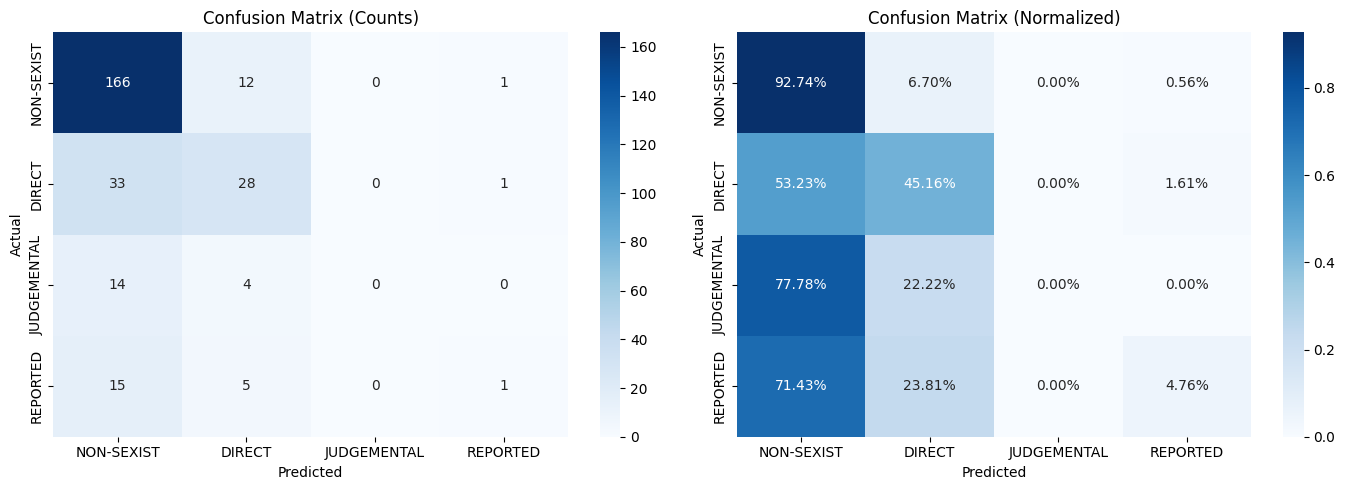



>>> 2. ERROR BREAKDOWN
Total errors: 85

Top 10 error types (True → Predicted):
---------------------------------------------
  DIRECT       → NON-SEXIST  :   33 errors
  REPORTED     → NON-SEXIST  :   15 errors
  JUDGEMENTAL  → NON-SEXIST  :   14 errors
  NON-SEXIST   → DIRECT      :   12 errors
  REPORTED     → DIRECT      :    5 errors
  JUDGEMENTAL  → DIRECT      :    4 errors
  NON-SEXIST   → REPORTED    :    1 errors
  DIRECT       → REPORTED    :    1 errors


>>> 3. CONFIDENCE ANALYSIS
Confidence Statistics:
----------------------------------------
Correct predictions   - Mean: 0.785, Std: 0.201
Incorrect predictions - Mean: 0.605, Std: 0.220


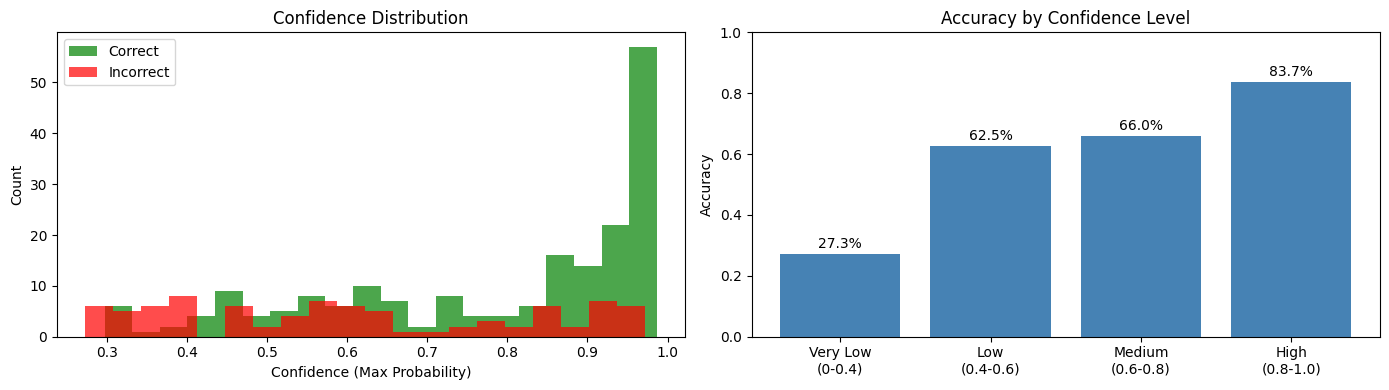



>>> 4. HIGH-CONFIDENCE ERRORS
High-Confidence Errors (confidence > 0.7)
Found: 29 errors

Text: kabul islamic emirate of afghanistan have announce the end of coeducation in the country cite gender harassmentfemale student will attend university on monday wednesday and saturday while tuesday thursday and sunday be fix for male...
True: REPORTED | Pred: NON-SEXIST | Conf: 0.851
Probs: {'NON-SEXIST': np.float32(0.851), 'DIRECT': np.float32(0.034), 'JUDGEMENTAL': np.float32(0.032), 'REPORTED': np.float32(0.082)}
------------------------------------------------------------

Text: the violent antifeminism of a farright movement that see principally a vessel for breed a new white generation express itself in a fixation on a return to traditional gender rolesworth every minute to read take 5 min out of your sun...
True: REPORTED | Pred: NON-SEXIST | Conf: 0.966
Probs: {'NON-SEXIST': np.float32(0.966), 'DIRECT': np.float32(0.011), 'JUDGEMENTAL': np.float32(0.01), 'REPORTED': np.float32(0.013)

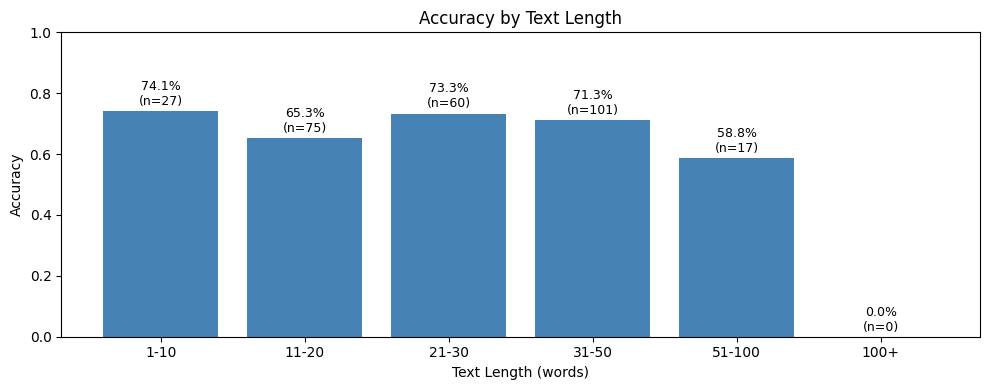



>>> 7. PER-CLASS ANALYSIS

CLASS: NON-SEXIST
Accuracy: 166/179 (92.7%)

Confused with:
  → DIRECT: 12 (92.3%)
  → REPORTED: 1 (7.7%)

Example errors:
  • "isa hot girl summer now pop yall shit..."
    Predicted: DIRECT
  • "my baby call me mommy sha for the first time today twice yall dont understand how hype that make me ..."
    Predicted: DIRECT
  • "yup i hate when men rape and kill woman..."
    Predicted: DIRECT

CLASS: DIRECT
Accuracy: 28/62 (45.2%)

Confused with:
  → NON-SEXIST: 33 (97.1%)
  → REPORTED: 1 (2.9%)

Example errors:
  • "maybe something involve her get gangbanged..."
    Predicted: NON-SEXIST
  • "ah look gender role be back too the dont believe their own lie..."
    Predicted: NON-SEXIST
  • "that gold digger be nice but the picture and set up for them be elite pinwork be like the revealing ..."
    Predicted: NON-SEXIST

CLASS: JUDGEMENTAL
Accuracy: 0/18 (0.0%)

Confused with:
  → NON-SEXIST: 14 (77.8%)
  → DIRECT: 4 (22.2%)

Example errors:
  • "dear fan can 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_true = y_test
y_pred = y_test_pred_labels
y_proba = y_test_pred  # Probability Matrix
texts = test_df['tweet'].tolist()

# Full analysis on the best model between custom nn with LSTM layer
error_df = run_full_analysis(y_true, y_pred, y_proba, texts)

### Error Analysis on best Transformer model

In [73]:
# 1. TRUE LABELS
y_true = test_labels

# 2. PREDICTIONS (y_pred)
y_pred = np.argmax(best_predictions, axis=1)

# 3. PROBABILITES (y_pred_proba)
y_pred_proba = best_predictions  # shape: (n_samples, 4)

# 4. TWEETS
texts = test_df['tweet'].tolist()

# Normalize the probabilities with softmax
if not np.allclose(y_pred_proba.sum(axis=1), 1, rtol=0.01):
    from scipy.special import softmax
    y_pred_proba = softmax(y_pred_proba, axis=1)




>>> 1. CONFUSION MATRIX


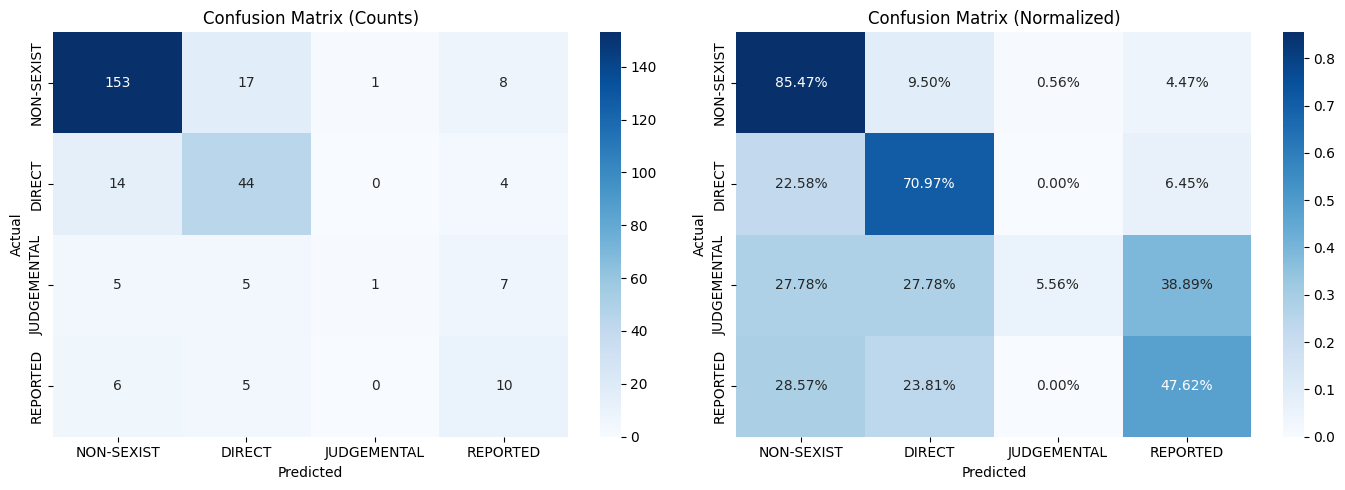



>>> 2. CLASSIFICATION REPORT
              precision    recall  f1-score   support

  NON-SEXIST       0.86      0.85      0.86       179
      DIRECT       0.62      0.71      0.66        62
 JUDGEMENTAL       0.50      0.06      0.10        18
    REPORTED       0.34      0.48      0.40        21

    accuracy                           0.74       280
   macro avg       0.58      0.52      0.50       280
weighted avg       0.74      0.74      0.73       280



>>> 3. PRECISION-RECALL CURVES


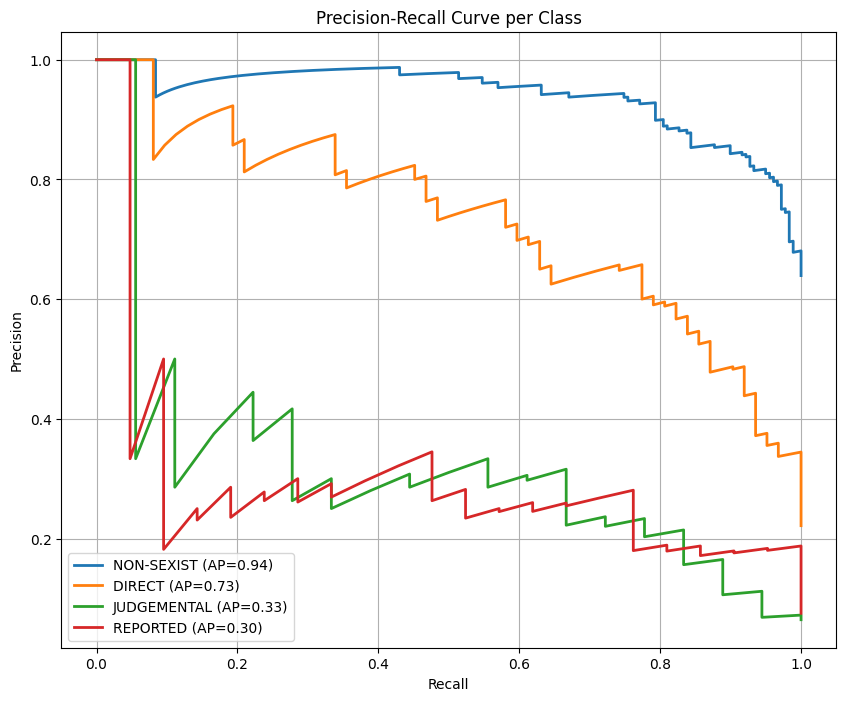



>>> 4. MISCLASSIFIED EXAMPLES
Classification Report:
              precision    recall  f1-score   support

  NON-SEXIST       0.86      0.85      0.86       179
      DIRECT       0.62      0.71      0.66        62
 JUDGEMENTAL       0.50      0.06      0.10        18
    REPORTED       0.34      0.48      0.40        21

    accuracy                           0.74       280
   macro avg       0.58      0.52      0.50       280
weighted avg       0.74      0.74      0.73       280


Total misclassified samples: 72

First 10 misclassified examples:

Sample 5:
 Text       : “I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL
 True label : NON-SEXIST
 Predicted  : DIRECT
-----

Sample 9:
 Text       : Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf
 True label : NON-SEXIST
 Predicted  : REPORTED
-----

Sample 13:
 Text       : "The

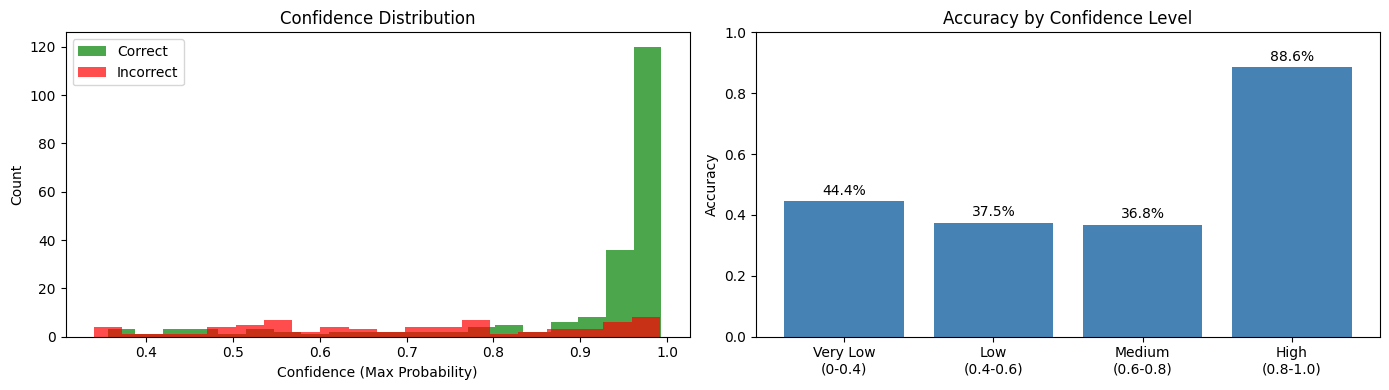



>>> 7. HIGH-CONFIDENCE ERRORS
High-Confidence Errors (confidence > 0.7)
Found: 37 errors

Text: Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf...
True: NON-SEXIST | Pred: REPORTED | Conf: 0.726
Probs: {'NON-SEXIST': np.float32(0.117), 'DIRECT': np.float32(0.025), 'JUDGEMENTAL': np.float32(0.132), 'REPORTED': np.float32(0.726)}
------------------------------------------------------------

Text: "The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generation expresses itself in a fixation on a return to “traditional” gender roles"Worth every minute to read - take 5 min out of your Sun...
True: REPORTED | Pred: NON-SEXIST | Conf: 0.787
Probs: {'NON-SEXIST': np.float32(0.787), 'DIRECT': np.float32(0.025), 'JUDGEMENTAL': np.float32(0.098), 'REPORTED': np.float32(0.089)}
----------------------------------------------

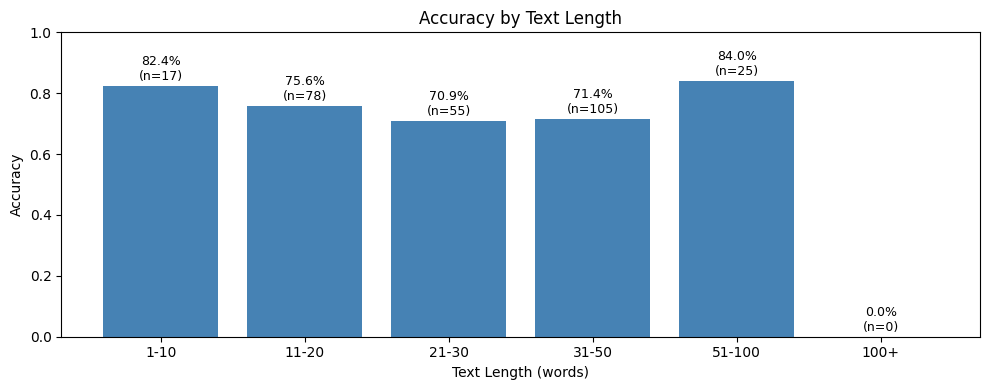



>>> 10. PER-CLASS ANALYSIS

CLASS: NON-SEXIST
Accuracy: 153/179 (85.5%)

Confused with:
  → DIRECT: 17 (65.4%)
  → REPORTED: 8 (30.8%)
  → JUDGEMENTAL: 1 (3.8%)

Example errors:
  • "“I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL..."
    Predicted: DIRECT
  • "Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender har..."
    Predicted: REPORTED
  • "@EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis..."
    Predicted: DIRECT

CLASS: DIRECT
Accuracy: 44/62 (71.0%)

Confused with:
  → NON-SEXIST: 14 (77.8%)
  → REPORTED: 4 (22.2%)

Example errors:
  • "@MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies...."
    Predicted: NON-SEXIST
  • "@Catoishere @HatClub @RahnniFitteds That gold digger is nice but the picture and set up for them are..."
    Predicted: NON-SEXIST
  • "@DaddyBrianMC @roadhouse2100 @stlct

In [74]:
# Full analysis on the transformer
error_df = run_full_analysis(
    y_true=y_true,
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
    texts=texts
)


# [Error Analysis on Spanish Tweets]

### Error Analysis on best LSTM Model



>>> 1. CONFUSION MATRIX


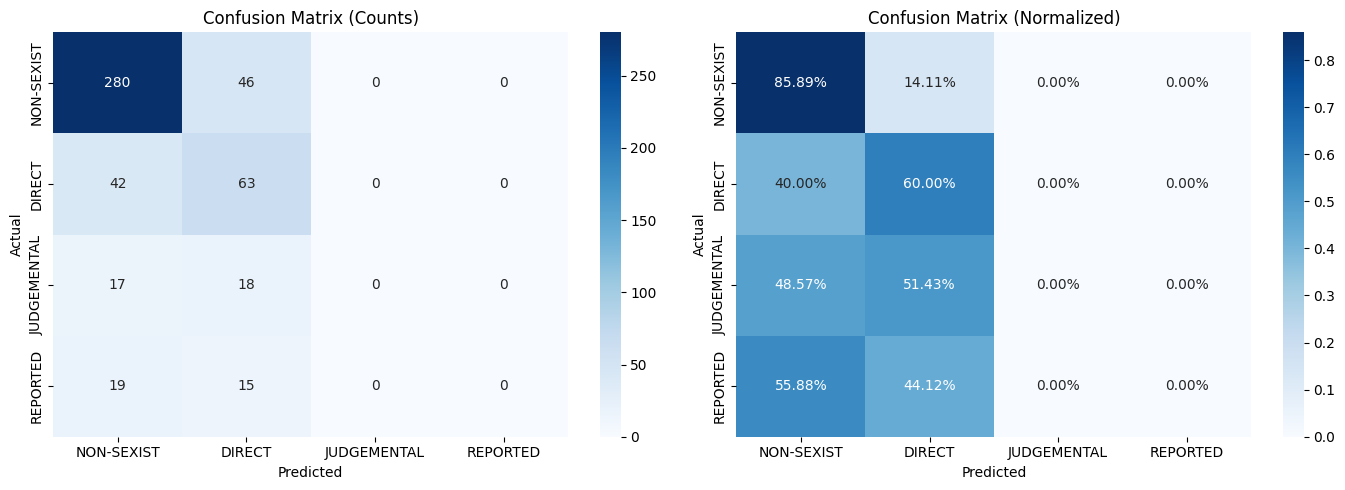



>>> 2. CLASSIFICATION REPORT
              precision    recall  f1-score   support

  NON-SEXIST       0.78      0.86      0.82       326
      DIRECT       0.44      0.60      0.51       105
 JUDGEMENTAL       0.00      0.00      0.00        35
    REPORTED       0.00      0.00      0.00        34

    accuracy                           0.69       500
   macro avg       0.31      0.36      0.33       500
weighted avg       0.60      0.69      0.64       500



>>> 3. PRECISION-RECALL CURVES


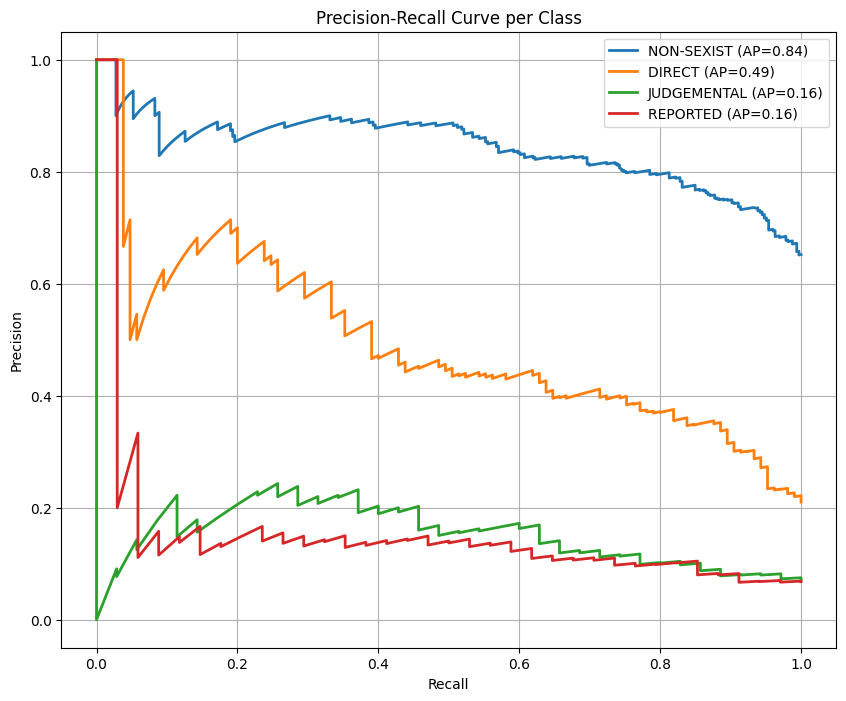



>>> 4. MISCLASSIFIED EXAMPLES
Classification Report:
              precision    recall  f1-score   support

  NON-SEXIST       0.78      0.86      0.82       326
      DIRECT       0.44      0.60      0.51       105
 JUDGEMENTAL       0.00      0.00      0.00        35
    REPORTED       0.00      0.00      0.00        34

    accuracy                           0.69       500
   macro avg       0.31      0.36      0.33       500
weighted avg       0.60      0.69      0.64       500


Total misclassified samples: 157

First 10 misclassified examples:

Sample 1:
 Text       : denunciar el discriminación múltiple e interseccional que sufrir el mujer con psicosocial vía
 True label : REPORTED
 Predicted  : DIRECT
-----

Sample 8:
 Text       : no todo el hombre ser delincuente pero prácticamente todo el delincuente ser hombre
 True label : NON-SEXIST
 Predicted  : DIRECT
-----

Sample 11:
 Text       : aula de nivel secundario 2022el dejar en evidencia el privilegio de él masculino en el

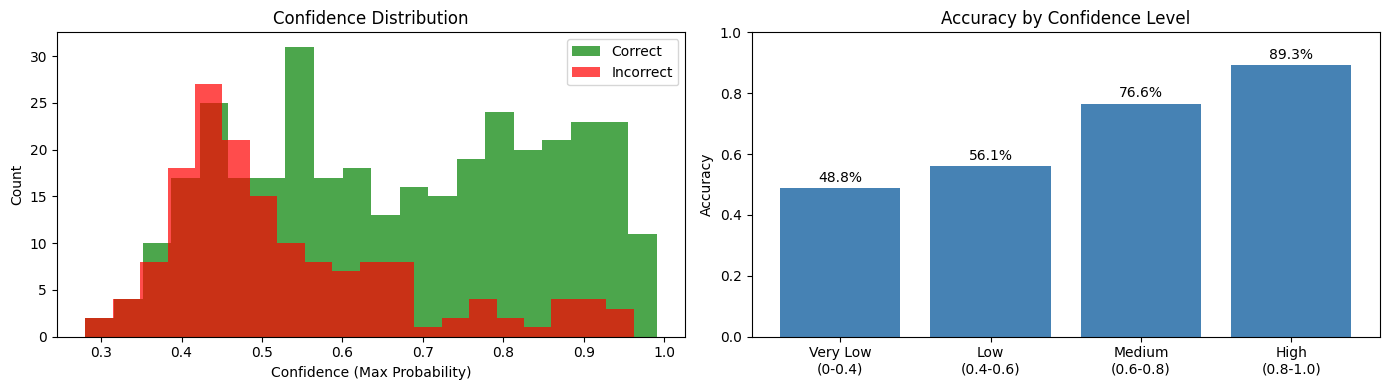



>>> 7. HIGH-CONFIDENCE ERRORS
High-Confidence Errors (confidence > 0.7)
Found: 21 errors

Text: btw yo caer mucho mal cara delevine y el verdad que si remerar de peg the patriarchy no ayudar...
True: DIRECT | Pred: NON-SEXIST | Conf: 0.911
Probs: {'NON-SEXIST': np.float32(0.911), 'DIRECT': np.float32(0.058), 'JUDGEMENTAL': np.float32(0.014), 'REPORTED': np.float32(0.017)}
------------------------------------------------------------

Text: no sólo ser valiente cuando denunciar ser valiente cuando sobrevivir así segar en silencio valiente ser todo el que hablar y el que no porque acá seguir seguir de pie...
True: REPORTED | Pred: NON-SEXIST | Conf: 0.802
Probs: {'NON-SEXIST': np.float32(0.802), 'DIRECT': np.float32(0.117), 'JUDGEMENTAL': np.float32(0.037), 'REPORTED': np.float32(0.044)}
------------------------------------------------------------

Text: dra cordero villega y acoso sexual en uno mismo frase yo hacer pensar en el más vomitivo de el cuadro plástico...
True: JUDGEMENTAL | 

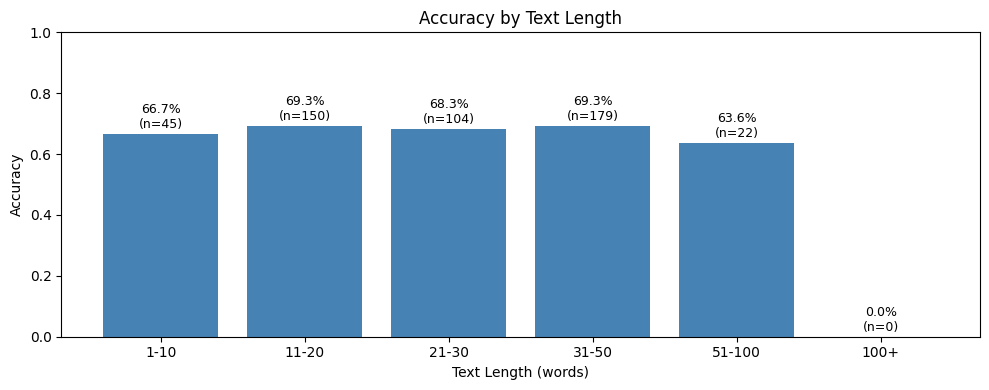



>>> 10. PER-CLASS ANALYSIS

CLASS: NON-SEXIST
Accuracy: 280/326 (85.9%)

Confused with:
  → DIRECT: 46 (100.0%)

Example errors:
  • "no todo el hombre ser delincuente pero prácticamente todo el delincuente ser hombre..."
    Predicted: DIRECT
  • "ambos él ser así como hacer comentario misogino y asesinar mujer cis..."
    Predicted: DIRECT
  • "café con aroma de mujer rebelde betty el feo ser netflix o ser blim..."
    Predicted: DIRECT

CLASS: DIRECT
Accuracy: 63/105 (60.0%)

Confused with:
  → NON-SEXIST: 42 (100.0%)

Example errors:
  • "yo no yo él hacer pq yo él ir a terminar arrancar sin querer pues siempre tanto marimacho y o..."
    Predicted: NON-SEXIST
  • "el y con lalo moro ser ambiguo por uno lado a el mayoría de el mujer que soler tomar él foto con él ..."
    Predicted: NON-SEXIST
  • "btw yo caer mucho mal cara delevine y el verdad que si remerar de peg the patriarchy no ayudar..."
    Predicted: NON-SEXIST

CLASS: JUDGEMENTAL
Accuracy: 0/35 (0.0%)

Confused with:
 

In [ ]:
y_true = y_test_es
y_pred = y_test_pred_labels_es
y_proba = y_test_pred_es  # Probability Matrix
texts_es = test_df_es['tweet'].tolist()

# Full analysis on the best model between custom nn with LSTM layer
error_df = run_full_analysis(y_true, y_pred, y_proba, texts_es)

### Error Analysis on Spanish Transformer

In [ ]:
# 1. TRUE LABELS
y_true = test_labels_s

# 2. PREDICTIONS (y_pred)
y_pred = np.argmax(test_predictions_s, axis=1)

# 3. PROBABILITES (y_pred_proba)
y_pred_proba = test_predictions_s  # shape: (n_samples, 4)

# 4. TWEETS
texts = test_df_es['tweet'].tolist()

# Normalize the probabilities with softmax
if not np.allclose(y_pred_proba.sum(axis=1), 1, rtol=0.01):
    from scipy.special import softmax
    y_pred_proba = softmax(y_pred_proba, axis=1)



>>> 1. CONFUSION MATRIX


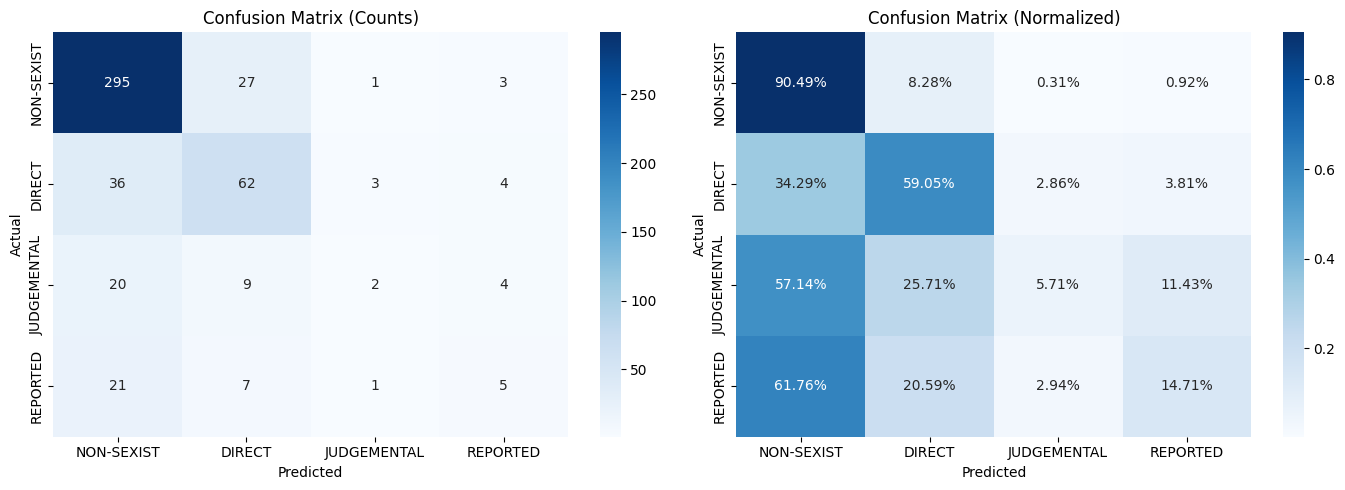



>>> 2. CLASSIFICATION REPORT
              precision    recall  f1-score   support

  NON-SEXIST       0.79      0.90      0.85       326
      DIRECT       0.59      0.59      0.59       105
 JUDGEMENTAL       0.29      0.06      0.10        35
    REPORTED       0.31      0.15      0.20        34

    accuracy                           0.73       500
   macro avg       0.50      0.42      0.43       500
weighted avg       0.68      0.73      0.70       500



>>> 3. PRECISION-RECALL CURVES


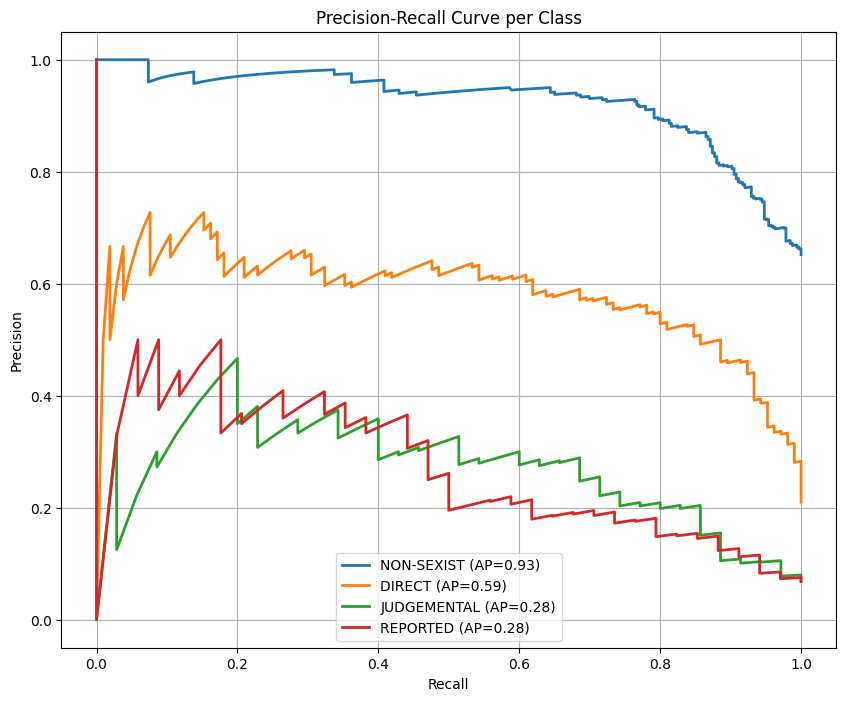



>>> 4. MISCLASSIFIED EXAMPLES
Classification Report:
              precision    recall  f1-score   support

  NON-SEXIST       0.79      0.90      0.85       326
      DIRECT       0.59      0.59      0.59       105
 JUDGEMENTAL       0.29      0.06      0.10        35
    REPORTED       0.31      0.15      0.20        34

    accuracy                           0.73       500
   macro avg       0.50      0.42      0.43       500
weighted avg       0.68      0.73      0.70       500


Total misclassified samples: 136

First 10 misclassified examples:

Sample 1:
 Text       : denunciar el discriminación múltiple e interseccional que sufrir el mujer con psicosocial vía
 True label : REPORTED
 Predicted  : NON-SEXIST
-----

Sample 10:
 Text       : saber alguno vez antes de dormir yo poner a pensar que el mujer no deber tener el derecho a opinar sin el permiso de uno hombre
 True label : DIRECT
 Predicted  : JUDGEMENTAL
-----

Sample 11:
 Text       : aula de nivel secundario 2022el deja

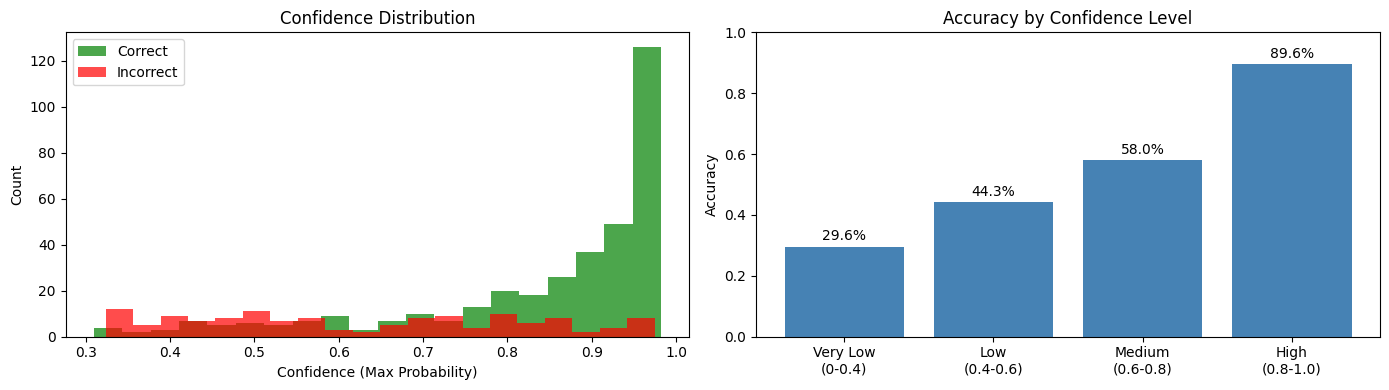



>>> 7. HIGH-CONFIDENCE ERRORS
High-Confidence Errors (confidence > 0.7)
Found: 56 errors

Text: yo no yo él hacer pq yo él ir a terminar arrancar sin querer pues siempre tanto marimacho y o...
True: DIRECT | Pred: NON-SEXIST | Conf: 0.783
Probs: {'NON-SEXIST': np.float32(0.783), 'DIRECT': np.float32(0.163), 'JUDGEMENTAL': np.float32(0.015), 'REPORTED': np.float32(0.04)}
------------------------------------------------------------

Text: btw yo caer mucho mal cara delevine y el verdad que si remerar de peg the patriarchy no ayudar...
True: DIRECT | Pred: NON-SEXIST | Conf: 0.941
Probs: {'NON-SEXIST': np.float32(0.941), 'DIRECT': np.float32(0.032), 'JUDGEMENTAL': np.float32(0.009), 'REPORTED': np.float32(0.017)}
------------------------------------------------------------

Text: el reniegar de el medida profecundidadno querer pobre pero ese sí sin estereotipo de género desgobernante...
True: JUDGEMENTAL | Pred: NON-SEXIST | Conf: 0.726
Probs: {'NON-SEXIST': np.float32(0.726), 'DIRECT':

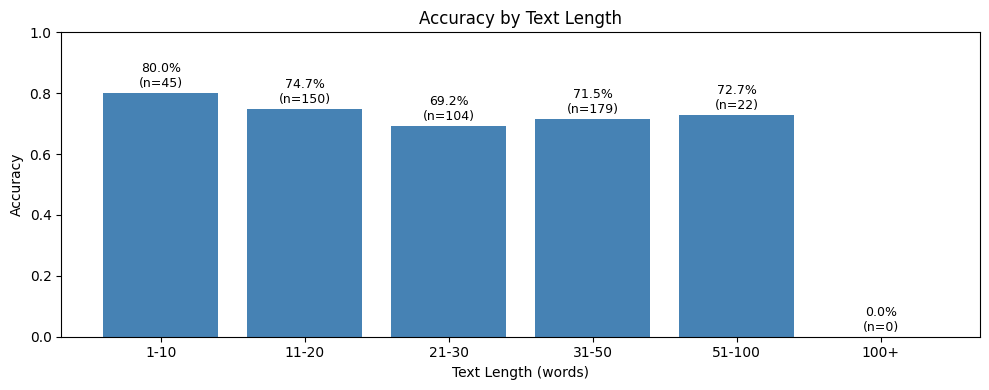



>>> 10. PER-CLASS ANALYSIS

CLASS: NON-SEXIST
Accuracy: 295/326 (90.5%)

Confused with:
  → DIRECT: 27 (87.1%)
  → REPORTED: 3 (9.7%)
  → JUDGEMENTAL: 1 (3.2%)

Example errors:
  • "ambos él ser así como hacer comentario misogino y asesinar mujer cis..."
    Predicted: JUDGEMENTAL
  • "café con aroma de mujer rebelde betty el feo ser netflix o ser blim..."
    Predicted: DIRECT
  • "y sobre el vato que abandonar a su pareja e hijo ese wey él ir sin más y creer que él él investigar ..."
    Predicted: REPORTED

CLASS: DIRECT
Accuracy: 62/105 (59.0%)

Confused with:
  → NON-SEXIST: 36 (83.7%)
  → REPORTED: 4 (9.3%)
  → JUDGEMENTAL: 3 (7.0%)

Example errors:
  • "saber alguno vez antes de dormir yo poner a pensar que el mujer no deber tener el derecho a opinar s..."
    Predicted: JUDGEMENTAL
  • "yo no yo él hacer pq yo él ir a terminar arrancar sin querer pues siempre tanto marimacho y o..."
    Predicted: NON-SEXIST
  • "el y con lalo moro ser ambiguo por uno lado a el mayoría de el 

In [ ]:
# Full analysis on the transformer
error_df = run_full_analysis(
    y_true=y_true,
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
    texts=texts
)

# [Error Analysis on Transformer trained with spanish tweets and tested with english tweets]


In [ ]:
# 1. TRUE LABELS
y_true = test_labels_z

# 2. PREDICTIONS (y_pred)
y_pred = np.argmax(test_predictions_z, axis=1)

# 3. PROBABILITES (y_pred_proba)
y_pred_proba = test_predictions_z  # shape: (n_samples, 4)

# 4. TWEETS
texts = test_df['tweet'].tolist()

# Normalize the probabilities with softmax
if not np.allclose(y_pred_proba.sum(axis=1), 1, rtol=0.01):
    from scipy.special import softmax
    y_pred_proba = softmax(y_pred_proba, axis=1)



>>> 1. CONFUSION MATRIX


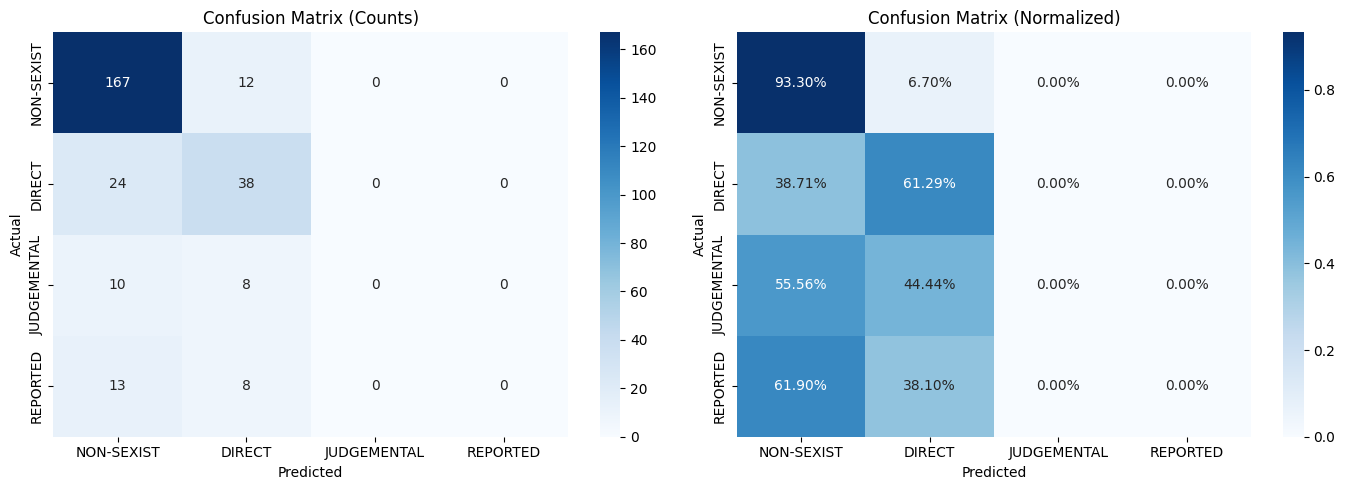



>>> 2. CLASSIFICATION REPORT
              precision    recall  f1-score   support

  NON-SEXIST       0.78      0.93      0.85       179
      DIRECT       0.58      0.61      0.59        62
 JUDGEMENTAL       0.00      0.00      0.00        18
    REPORTED       0.00      0.00      0.00        21

    accuracy                           0.73       280
   macro avg       0.34      0.39      0.36       280
weighted avg       0.63      0.73      0.67       280



>>> 3. PRECISION-RECALL CURVES


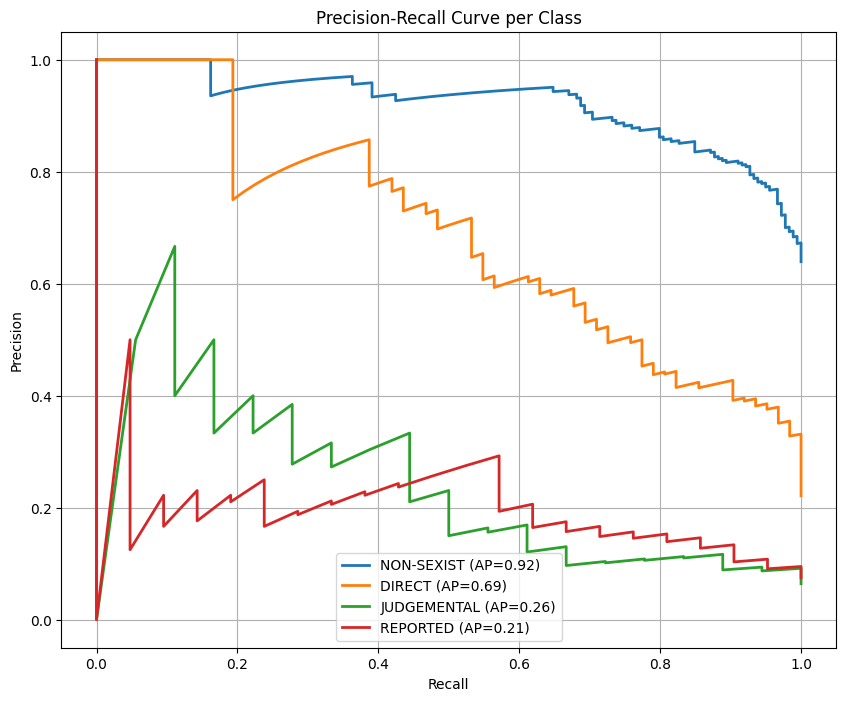



>>> 4. MISCLASSIFIED EXAMPLES
Classification Report:
              precision    recall  f1-score   support

  NON-SEXIST       0.78      0.93      0.85       179
      DIRECT       0.58      0.61      0.59        62
 JUDGEMENTAL       0.00      0.00      0.00        18
    REPORTED       0.00      0.00      0.00        21

    accuracy                           0.73       280
   macro avg       0.34      0.39      0.36       280
weighted avg       0.63      0.73      0.67       280


Total misclassified samples: 75

First 10 misclassified examples:

Sample 6:
 Text       : maybe something involve her get gangbanged
 True label : DIRECT
 Predicted  : NON-SEXIST
-----

Sample 8:
 Text       : kabul islamic emirate of afghanistan have announce the end of coeducation in the country cite gender harassmentfemale student will attend university on monday wednesday and saturday while tuesday thursday and sunday be fix for male
 True label : REPORTED
 Predicted  : NON-SEXIST
-----

Sample 13:


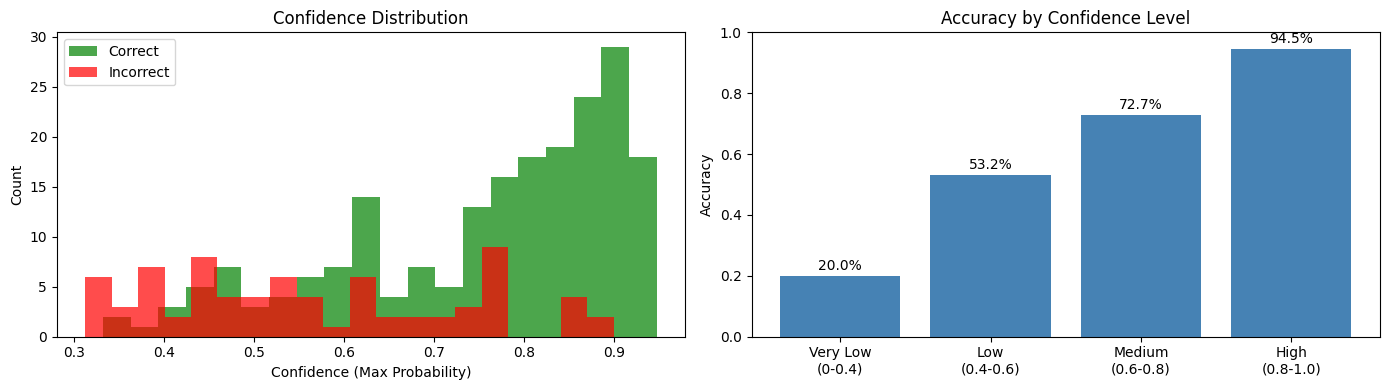



>>> 7. HIGH-CONFIDENCE ERRORS
High-Confidence Errors (confidence > 0.7)
Found: 20 errors

Text: kabul islamic emirate of afghanistan have announce the end of coeducation in the country cite gender harassmentfemale student will attend university on monday wednesday and saturday while tuesday thursday and sunday be fix for male...
True: REPORTED | Pred: NON-SEXIST | Conf: 0.777
Probs: {'NON-SEXIST': np.float32(0.777), 'DIRECT': np.float32(0.075), 'JUDGEMENTAL': np.float32(0.059), 'REPORTED': np.float32(0.089)}
------------------------------------------------------------

Text: the violent antifeminism of a farright movement that see principally a vessel for breed a new white generation express itself in a fixation on a return to traditional gender rolesworth every minute to read take 5 min out of your sun...
True: REPORTED | Pred: NON-SEXIST | Conf: 0.758
Probs: {'NON-SEXIST': np.float32(0.758), 'DIRECT': np.float32(0.071), 'JUDGEMENTAL': np.float32(0.098), 'REPORTED': np.float32(0.074

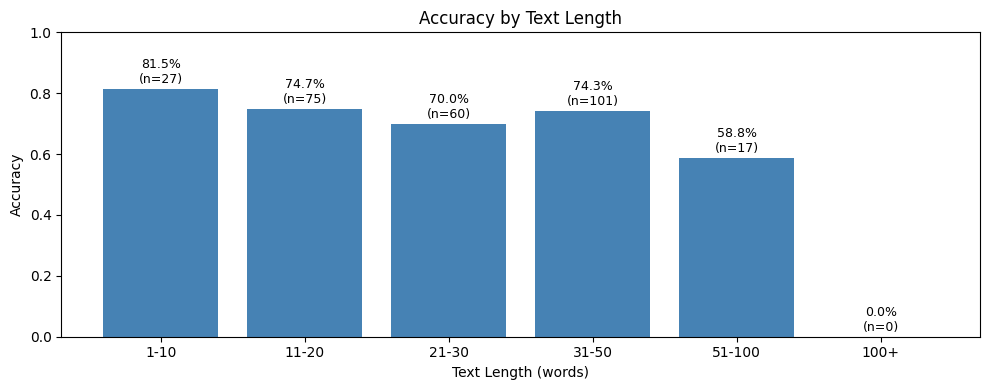



>>> 10. PER-CLASS ANALYSIS

CLASS: NON-SEXIST
Accuracy: 167/179 (93.3%)

Confused with:
  → DIRECT: 12 (100.0%)

Example errors:
  • "he try to expose this gold digger but it backfire 90 day fiancée b via..."
    Predicted: DIRECT
  • "stop dont lie to these people lady dont let this man trick you out of the great organ of your life c..."
    Predicted: DIRECT
  • "lady dont have a miscarriage in louisiana if you do in addition to probably have your friend and fam..."
    Predicted: DIRECT

CLASS: DIRECT
Accuracy: 38/62 (61.3%)

Confused with:
  → NON-SEXIST: 24 (100.0%)

Example errors:
  • "maybe something involve her get gangbanged..."
    Predicted: NON-SEXIST
  • "ah look gender role be back too the dont believe their own lie..."
    Predicted: NON-SEXIST
  • "hot girl cant get nowhere without a gps..."
    Predicted: NON-SEXIST

CLASS: JUDGEMENTAL
Accuracy: 0/18 (0.0%)

Confused with:
  → NON-SEXIST: 10 (55.6%)
  → DIRECT: 8 (44.4%)

Example errors:
  • "dear fan can we not har

In [ ]:
# Full analysis on the transformer
error_df = run_full_analysis(
    y_true=y_true,
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
    texts=texts
)

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.